In [1]:
import os
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
from tqdm import tqdm
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt


plt.rcParams["image.cmap"] = "jet"

In [2]:
# Setting path
# path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs/")
# Join paths
MODEL_SAVE_PATH = path / 'trained_model/' # Automatically adds the correct separator
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

/net/micdata/data2/12IDC/ptychosaxs/trained_model


In [3]:
# Load preprocessed data
num='DELETE'#17
numDPs=10800#10000

# Load the data
data_path = os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir{num}_WAXS_MASK_numDPs{numDPs}.npz'))
data = np.load(data_path)

# Extract the arrays
amp_conv_red = data['amp_conv_red']
amp_ideal_red = data['amp_ideal_red']
amp_probe_red = data['amp_probe_red']

In [4]:
# Set the number of patterns in test, train or validation set
NTEST = amp_conv_red.shape[0]//4
NTRAIN = amp_conv_red.shape[0]-NTEST
NVALID = NTEST//2 # NTRAIN//

print(NTRAIN,NTEST,NVALID)

8100 2700 1350


In [5]:
EPOCHS = 500
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS*16
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

no_probe=True
H,W=amp_ideal_red[0].shape[0],amp_ideal_red[0].shape[1]
print(H,W)

GPUs: 2 Batch size: 32 Learning rate: 0.002
256 256


In [6]:
#separate data and convert to tensors and shuffle
no_probe=True

tst_start = amp_conv_red.shape[0]-NTEST

X_train = amp_conv_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = amp_conv_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Xp_train = amp_probe_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Xp_test = amp_probe_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Y_I_train = amp_ideal_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp_ideal_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

X_train, Xp_train, Y_I_train = shuffle(X_train, Xp_train, Y_I_train, random_state=0)

#Training data
X_train_tensor = torch.Tensor(X_train)
Xp_train_tensor = torch.Tensor(Xp_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 

#Test data
X_test_tensor = torch.Tensor(X_test)
Xp_test_tensor = torch.Tensor(Xp_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 

print(X_train_tensor.shape,Xp_train_tensor.shape, Y_I_train_tensor.shape)


if no_probe:
    train_data = TensorDataset(X_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)
else:
    train_data = TensorDataset(X_train_tensor,Xp_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)


N_TRAIN = X_train_tensor.shape[0]

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-NVALID,NVALID])
print(len(train_data2),len(train_data2[0]),len(valid_data),len(test_data))


#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256])
6750 2 1350 2700


In [7]:
import sys
import os
import importlib

# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/')))

# # First, try to import the module
# try:
#     import encoder1_no_Unet
#     # Force reload the module
#     importlib.reload(encoder1_no_Unet)
#     # Now import the class from the freshly reloaded module
#     from encoder1_no_Unet import recon_model
#     print("Successfully imported recon_model")
#     unet_status = "no_Unet"
#     loss_function = "L2"
# except Exception as e:
#     print(f"Import error: {e}")
    
#First, try to import the module
try:
    import encoder1
    importlib.reload(encoder1)
    # Now import the class from the freshly reloaded module
    from encoder1 import recon_model
    print("Successfully imported recon_model")
    unet_status = "Unet"
    loss_function = "pearson_loss"
    #loss_function = "L2"
except Exception as e:
    print(f"Import error: {e}")


model = recon_model()
load_prev_model=False

Successfully imported recon_model


In [8]:
if no_probe:
    for ampsI,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI)#,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break
else:
    for ampsI,ampsP,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #model = nn.parallel.DistributedDataParallel(model) #Default all devices
    model = nn.DataParallel(model)

model = model.to(device)
print(model)

batch size: torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32
Let's use 2 GPUs!
DataParallel(
  (module): recon_model(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder3): Sequential(
      (0): Co

In [9]:
def pearson_loss(output, target):
    """
    Compute 1 - Pearson correlation coefficient as a loss function.
    Args:
        output: Predicted values (B, C, H, W)
        target: Target values (B, C, H, W)
    Returns:
        loss: 1 - correlation (to minimize)
    """
    # Flatten the spatial dimensions
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    
    # Mean of each image
    output_mean = output_flat.mean(dim=1, keepdim=True)
    target_mean = target_flat.mean(dim=1, keepdim=True)
    
    # Centered variables
    output_centered = output_flat - output_mean
    target_centered = target_flat - target_mean
    
    # Correlation
    numerator = (output_centered * target_centered).sum(dim=1)
    denominator = torch.sqrt((output_centered**2).sum(dim=1) * (target_centered**2).sum(dim=1))
    
    # Avoid division by zero
    correlation = numerator / (denominator + 1e-8)
    
    # Average over batch and convert to loss (1 - correlation)
    loss = 1 - correlation.mean()
    
    #Negaive pearson loss
    #loss = 1 + correlation.mean()
    
    return loss

In [10]:
#Optimizer details
iterations_per_epoch = np.floor((NTRAIN-NVALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 (6) number of iterations, step_size is half cycle
print(iterations_per_epoch)
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))



#criterion = nn.L1Loss()
#criterion = nn.MSELoss()
    

optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
                                              
                                            
#Function to update saved model if validation loss is minimum

def update_saved_model(model, path, current_epoch, best_val_loss):
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Save the best overall model
    if (NGPUS>1):    
        torch.save(model.module.state_dict(), path / f'best_model_{num}_WAXS_MASK_{unet_status}_{loss_function}.pth')
    else:
        torch.save(model.module.state_dict(), path / f'best_model_{num}_WAXS_MASK_{unet_status}_{loss_function}.pth')
    
    # Define epoch intervals (50, 100, 150, etc.)
    epoch_intervals = [2, 10, 25, 50, 100, 150, 200, 250, 300, 400, 500]
    
    # For each interval, save the best model within that interval
    for interval in epoch_intervals:
        if current_epoch <= interval:
            # Create a filename that includes the epoch interval
            interval_filename = f'best_model_{num}_WAXS_MASK_{unet_status}_epoch_{interval}_{loss_function}.pth'
            interval_path = path / interval_filename
            
            # If this is the first time we're saving for this interval, save the model
            if not interval_path.exists():
                if (NGPUS>1):
                    torch.save(model.module.state_dict(), interval_path)
                else:
                    torch.save(model.module.state_dict(), interval_path)
                print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")
            # If we already have a model for this interval, only update if the current loss is better
            else:
                # Load the previous best loss for this interval
                prev_loss_path = path / f'best_loss_epoch_{num}_WAXS_MASK_{unet_status}_{interval}_{loss_function}.txt'
                if prev_loss_path.exists():
                    with open(prev_loss_path, 'r') as f:
                        prev_best_loss = float(f.read().strip())
                    
                    # Update if current loss is better
                    if best_val_loss < prev_best_loss:
                        if (NGPUS>1):
                            torch.save(model.module.state_dict(), interval_path)
                        else:
                            torch.save(model.module.state_dict(), interval_path)
                        with open(prev_loss_path, 'w') as f:
                            f.write(str(best_val_loss))
                        print(f"Updating best model for epoch interval {interval} at epoch {current_epoch}")
                else:
                    # First time saving for this interval
                    if (NGPUS>1):
                        torch.save(model.module.state_dict(), interval_path)
                    else:
                        torch.save(model.module.state_dict(), interval_path)
                    with open(prev_loss_path, 'w') as f:
                        f.write(str(best_val_loss))
                    print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")



def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    
    for i, (ft_images,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass
        
        #Compute losses
        #loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_a = pearson_loss(pred_amps,amps)
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i]) 
    
def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    for j, (ft_images,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass

        #val_loss_a = criterion(pred_amps,amps)
        val_loss_a = pearson_loss(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j])
  
    #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH, metrics['current_epoch'], tot_val_loss/j)



211.0
LR step size is: 1266.0 which is every 6 epochs


In [11]:
# Initialize metrics dictionary with current_epoch
metrics = {
    'losses': [],
    'val_losses': [],
    'lrs': [],
    'best_val_loss': float('inf'),
    'current_epoch': 0
}

for epoch in range (EPOCHS):
    metrics['current_epoch'] = epoch  # Update current epoch in metrics
    
    #Set model to train mode
    model.train() 
    #Training loop
    train(trainloader,metrics)
    
    #Switch model to eval mode
    model.eval()
    
    #Validation loop
    validate(validloader,metrics)
    print('Epoch: %d | Total  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
    print('Epoch: %d | Amp | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
    print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

211it [00:23,  8.87it/s]


Saving improved model after Val Loss improved from inf to 0.04941
Saving best model for epoch interval 2 at epoch 0
Saving best model for epoch interval 10 at epoch 0
Saving best model for epoch interval 25 at epoch 0
Saving best model for epoch interval 50 at epoch 0
Saving best model for epoch interval 100 at epoch 0
Saving best model for epoch interval 150 at epoch 0
Saving best model for epoch interval 200 at epoch 0
Saving best model for epoch interval 250 at epoch 0
Saving best model for epoch interval 300 at epoch 0
Saving best model for epoch interval 400 at epoch 0
Saving best model for epoch interval 500 at epoch 0
Epoch: 0 | Total  | Train Loss: 0.05079 | Val Loss: 0.04941
Epoch: 0 | Amp | Train Loss: 0.05079 | Val Loss: 0.04941
Epoch: 0 | Ending LR: 0.000500 


211it [00:22,  9.56it/s]


Saving improved model after Val Loss improved from 0.04941 to 0.03334
Saving best model for epoch interval 2 at epoch 1
Saving best model for epoch interval 10 at epoch 1
Saving best model for epoch interval 25 at epoch 1
Saving best model for epoch interval 50 at epoch 1
Saving best model for epoch interval 100 at epoch 1
Saving best model for epoch interval 150 at epoch 1
Saving best model for epoch interval 200 at epoch 1
Saving best model for epoch interval 250 at epoch 1
Saving best model for epoch interval 300 at epoch 1
Saving best model for epoch interval 400 at epoch 1
Saving best model for epoch interval 500 at epoch 1
Epoch: 1 | Total  | Train Loss: 0.03418 | Val Loss: 0.03334
Epoch: 1 | Amp | Train Loss: 0.03418 | Val Loss: 0.03334
Epoch: 1 | Ending LR: 0.000800 


211it [00:21,  9.61it/s]


Saving improved model after Val Loss improved from 0.03334 to 0.03067
Updating best model for epoch interval 2 at epoch 2
Updating best model for epoch interval 10 at epoch 2
Updating best model for epoch interval 25 at epoch 2
Updating best model for epoch interval 50 at epoch 2
Updating best model for epoch interval 100 at epoch 2
Updating best model for epoch interval 150 at epoch 2
Updating best model for epoch interval 200 at epoch 2
Updating best model for epoch interval 250 at epoch 2
Updating best model for epoch interval 300 at epoch 2
Updating best model for epoch interval 400 at epoch 2
Updating best model for epoch interval 500 at epoch 2
Epoch: 2 | Total  | Train Loss: 0.03046 | Val Loss: 0.03067
Epoch: 2 | Amp | Train Loss: 0.03046 | Val Loss: 0.03067
Epoch: 2 | Ending LR: 0.001100 


211it [00:22,  9.50it/s]


Saving improved model after Val Loss improved from 0.03067 to 0.02761
Updating best model for epoch interval 10 at epoch 3
Updating best model for epoch interval 25 at epoch 3
Updating best model for epoch interval 50 at epoch 3
Updating best model for epoch interval 100 at epoch 3
Updating best model for epoch interval 150 at epoch 3
Updating best model for epoch interval 200 at epoch 3
Updating best model for epoch interval 250 at epoch 3
Updating best model for epoch interval 300 at epoch 3
Updating best model for epoch interval 400 at epoch 3
Updating best model for epoch interval 500 at epoch 3
Epoch: 3 | Total  | Train Loss: 0.02872 | Val Loss: 0.02761
Epoch: 3 | Amp | Train Loss: 0.02872 | Val Loss: 0.02761
Epoch: 3 | Ending LR: 0.001400 


211it [00:22,  9.55it/s]


Saving improved model after Val Loss improved from 0.02761 to 0.02713
Updating best model for epoch interval 10 at epoch 4
Updating best model for epoch interval 25 at epoch 4
Updating best model for epoch interval 50 at epoch 4
Updating best model for epoch interval 100 at epoch 4
Updating best model for epoch interval 150 at epoch 4
Updating best model for epoch interval 200 at epoch 4
Updating best model for epoch interval 250 at epoch 4
Updating best model for epoch interval 300 at epoch 4
Updating best model for epoch interval 400 at epoch 4
Updating best model for epoch interval 500 at epoch 4
Epoch: 4 | Total  | Train Loss: 0.02737 | Val Loss: 0.02713
Epoch: 4 | Amp | Train Loss: 0.02737 | Val Loss: 0.02713
Epoch: 4 | Ending LR: 0.001700 


211it [00:22,  9.47it/s]


Saving improved model after Val Loss improved from 0.02713 to 0.02658
Updating best model for epoch interval 10 at epoch 5
Updating best model for epoch interval 25 at epoch 5
Updating best model for epoch interval 50 at epoch 5
Updating best model for epoch interval 100 at epoch 5
Updating best model for epoch interval 150 at epoch 5
Updating best model for epoch interval 200 at epoch 5
Updating best model for epoch interval 250 at epoch 5
Updating best model for epoch interval 300 at epoch 5
Updating best model for epoch interval 400 at epoch 5
Updating best model for epoch interval 500 at epoch 5
Epoch: 5 | Total  | Train Loss: 0.02642 | Val Loss: 0.02658
Epoch: 5 | Amp | Train Loss: 0.02642 | Val Loss: 0.02658
Epoch: 5 | Ending LR: 0.002000 


211it [00:22,  9.51it/s]


Saving improved model after Val Loss improved from 0.02658 to 0.02493
Updating best model for epoch interval 10 at epoch 6
Updating best model for epoch interval 25 at epoch 6
Updating best model for epoch interval 50 at epoch 6
Updating best model for epoch interval 100 at epoch 6
Updating best model for epoch interval 150 at epoch 6
Updating best model for epoch interval 200 at epoch 6
Updating best model for epoch interval 250 at epoch 6
Updating best model for epoch interval 300 at epoch 6
Updating best model for epoch interval 400 at epoch 6
Updating best model for epoch interval 500 at epoch 6
Epoch: 6 | Total  | Train Loss: 0.02552 | Val Loss: 0.02493
Epoch: 6 | Amp | Train Loss: 0.02552 | Val Loss: 0.02493
Epoch: 6 | Ending LR: 0.001700 


211it [00:22,  9.30it/s]


Saving improved model after Val Loss improved from 0.02493 to 0.02380
Updating best model for epoch interval 10 at epoch 7
Updating best model for epoch interval 25 at epoch 7
Updating best model for epoch interval 50 at epoch 7
Updating best model for epoch interval 100 at epoch 7
Updating best model for epoch interval 150 at epoch 7
Updating best model for epoch interval 200 at epoch 7
Updating best model for epoch interval 250 at epoch 7
Updating best model for epoch interval 300 at epoch 7
Updating best model for epoch interval 400 at epoch 7
Updating best model for epoch interval 500 at epoch 7
Epoch: 7 | Total  | Train Loss: 0.02451 | Val Loss: 0.02380
Epoch: 7 | Amp | Train Loss: 0.02451 | Val Loss: 0.02380
Epoch: 7 | Ending LR: 0.001400 


211it [00:22,  9.44it/s]


Saving improved model after Val Loss improved from 0.02380 to 0.02307
Updating best model for epoch interval 10 at epoch 8
Updating best model for epoch interval 25 at epoch 8
Updating best model for epoch interval 50 at epoch 8
Updating best model for epoch interval 100 at epoch 8
Updating best model for epoch interval 150 at epoch 8
Updating best model for epoch interval 200 at epoch 8
Updating best model for epoch interval 250 at epoch 8
Updating best model for epoch interval 300 at epoch 8
Updating best model for epoch interval 400 at epoch 8
Updating best model for epoch interval 500 at epoch 8
Epoch: 8 | Total  | Train Loss: 0.02385 | Val Loss: 0.02307
Epoch: 8 | Amp | Train Loss: 0.02385 | Val Loss: 0.02307
Epoch: 8 | Ending LR: 0.001100 


211it [00:22,  9.49it/s]


Saving improved model after Val Loss improved from 0.02307 to 0.02272
Updating best model for epoch interval 10 at epoch 9
Updating best model for epoch interval 25 at epoch 9
Updating best model for epoch interval 50 at epoch 9
Updating best model for epoch interval 100 at epoch 9
Updating best model for epoch interval 150 at epoch 9
Updating best model for epoch interval 200 at epoch 9
Updating best model for epoch interval 250 at epoch 9
Updating best model for epoch interval 300 at epoch 9
Updating best model for epoch interval 400 at epoch 9
Updating best model for epoch interval 500 at epoch 9
Epoch: 9 | Total  | Train Loss: 0.02322 | Val Loss: 0.02272
Epoch: 9 | Amp | Train Loss: 0.02322 | Val Loss: 0.02272
Epoch: 9 | Ending LR: 0.000800 


211it [00:22,  9.55it/s]


Saving improved model after Val Loss improved from 0.02272 to 0.02269
Updating best model for epoch interval 10 at epoch 10
Updating best model for epoch interval 25 at epoch 10
Updating best model for epoch interval 50 at epoch 10
Updating best model for epoch interval 100 at epoch 10
Updating best model for epoch interval 150 at epoch 10
Updating best model for epoch interval 200 at epoch 10
Updating best model for epoch interval 250 at epoch 10
Updating best model for epoch interval 300 at epoch 10
Updating best model for epoch interval 400 at epoch 10
Updating best model for epoch interval 500 at epoch 10
Epoch: 10 | Total  | Train Loss: 0.02245 | Val Loss: 0.02269
Epoch: 10 | Amp | Train Loss: 0.02245 | Val Loss: 0.02269
Epoch: 10 | Ending LR: 0.000500 


211it [00:22,  9.52it/s]


Saving improved model after Val Loss improved from 0.02269 to 0.02103
Updating best model for epoch interval 25 at epoch 11
Updating best model for epoch interval 50 at epoch 11
Updating best model for epoch interval 100 at epoch 11
Updating best model for epoch interval 150 at epoch 11
Updating best model for epoch interval 200 at epoch 11
Updating best model for epoch interval 250 at epoch 11
Updating best model for epoch interval 300 at epoch 11
Updating best model for epoch interval 400 at epoch 11
Updating best model for epoch interval 500 at epoch 11
Epoch: 11 | Total  | Train Loss: 0.02158 | Val Loss: 0.02103
Epoch: 11 | Amp | Train Loss: 0.02158 | Val Loss: 0.02103
Epoch: 11 | Ending LR: 0.000200 


211it [00:22,  9.56it/s]


Saving improved model after Val Loss improved from 0.02103 to 0.02091
Updating best model for epoch interval 25 at epoch 12
Updating best model for epoch interval 50 at epoch 12
Updating best model for epoch interval 100 at epoch 12
Updating best model for epoch interval 150 at epoch 12
Updating best model for epoch interval 200 at epoch 12
Updating best model for epoch interval 250 at epoch 12
Updating best model for epoch interval 300 at epoch 12
Updating best model for epoch interval 400 at epoch 12
Updating best model for epoch interval 500 at epoch 12
Epoch: 12 | Total  | Train Loss: 0.02099 | Val Loss: 0.02091
Epoch: 12 | Amp | Train Loss: 0.02099 | Val Loss: 0.02091
Epoch: 12 | Ending LR: 0.000350 


211it [00:22,  9.45it/s]


Epoch: 13 | Total  | Train Loss: 0.02115 | Val Loss: 0.02131
Epoch: 13 | Amp | Train Loss: 0.02115 | Val Loss: 0.02131
Epoch: 13 | Ending LR: 0.000500 


211it [00:22,  9.48it/s]


Epoch: 14 | Total  | Train Loss: 0.02129 | Val Loss: 0.02159
Epoch: 14 | Amp | Train Loss: 0.02129 | Val Loss: 0.02159
Epoch: 14 | Ending LR: 0.000650 


211it [00:22,  9.52it/s]


Epoch: 15 | Total  | Train Loss: 0.02135 | Val Loss: 0.02117
Epoch: 15 | Amp | Train Loss: 0.02135 | Val Loss: 0.02117
Epoch: 15 | Ending LR: 0.000800 


211it [00:22,  9.48it/s]


Saving improved model after Val Loss improved from 0.02091 to 0.02051
Updating best model for epoch interval 25 at epoch 16
Updating best model for epoch interval 50 at epoch 16
Updating best model for epoch interval 100 at epoch 16
Updating best model for epoch interval 150 at epoch 16
Updating best model for epoch interval 200 at epoch 16
Updating best model for epoch interval 250 at epoch 16
Updating best model for epoch interval 300 at epoch 16
Updating best model for epoch interval 400 at epoch 16
Updating best model for epoch interval 500 at epoch 16
Epoch: 16 | Total  | Train Loss: 0.02101 | Val Loss: 0.02051
Epoch: 16 | Amp | Train Loss: 0.02101 | Val Loss: 0.02051
Epoch: 16 | Ending LR: 0.000950 


211it [00:22,  9.45it/s]


Epoch: 17 | Total  | Train Loss: 0.02089 | Val Loss: 0.02158
Epoch: 17 | Amp | Train Loss: 0.02089 | Val Loss: 0.02158
Epoch: 17 | Ending LR: 0.001100 


211it [00:22,  9.53it/s]


Saving improved model after Val Loss improved from 0.02051 to 0.01989
Updating best model for epoch interval 25 at epoch 18
Updating best model for epoch interval 50 at epoch 18
Updating best model for epoch interval 100 at epoch 18
Updating best model for epoch interval 150 at epoch 18
Updating best model for epoch interval 200 at epoch 18
Updating best model for epoch interval 250 at epoch 18
Updating best model for epoch interval 300 at epoch 18
Updating best model for epoch interval 400 at epoch 18
Updating best model for epoch interval 500 at epoch 18
Epoch: 18 | Total  | Train Loss: 0.02024 | Val Loss: 0.01989
Epoch: 18 | Amp | Train Loss: 0.02024 | Val Loss: 0.01989
Epoch: 18 | Ending LR: 0.000950 


211it [00:22,  9.50it/s]


Saving improved model after Val Loss improved from 0.01989 to 0.01935
Updating best model for epoch interval 25 at epoch 19
Updating best model for epoch interval 50 at epoch 19
Updating best model for epoch interval 100 at epoch 19
Updating best model for epoch interval 150 at epoch 19
Updating best model for epoch interval 200 at epoch 19
Updating best model for epoch interval 250 at epoch 19
Updating best model for epoch interval 300 at epoch 19
Updating best model for epoch interval 400 at epoch 19
Updating best model for epoch interval 500 at epoch 19
Epoch: 19 | Total  | Train Loss: 0.01973 | Val Loss: 0.01935
Epoch: 19 | Amp | Train Loss: 0.01973 | Val Loss: 0.01935
Epoch: 19 | Ending LR: 0.000800 


211it [00:22,  9.36it/s]


Epoch: 20 | Total  | Train Loss: 0.01902 | Val Loss: 0.01948
Epoch: 20 | Amp | Train Loss: 0.01902 | Val Loss: 0.01948
Epoch: 20 | Ending LR: 0.000650 


211it [00:22,  9.50it/s]


Saving improved model after Val Loss improved from 0.01935 to 0.01828
Updating best model for epoch interval 25 at epoch 21
Updating best model for epoch interval 50 at epoch 21
Updating best model for epoch interval 100 at epoch 21
Updating best model for epoch interval 150 at epoch 21
Updating best model for epoch interval 200 at epoch 21
Updating best model for epoch interval 250 at epoch 21
Updating best model for epoch interval 300 at epoch 21
Updating best model for epoch interval 400 at epoch 21
Updating best model for epoch interval 500 at epoch 21
Epoch: 21 | Total  | Train Loss: 0.01836 | Val Loss: 0.01828
Epoch: 21 | Amp | Train Loss: 0.01836 | Val Loss: 0.01828
Epoch: 21 | Ending LR: 0.000500 


211it [00:22,  9.57it/s]


Saving improved model after Val Loss improved from 0.01828 to 0.01750
Updating best model for epoch interval 25 at epoch 22
Updating best model for epoch interval 50 at epoch 22
Updating best model for epoch interval 100 at epoch 22
Updating best model for epoch interval 150 at epoch 22
Updating best model for epoch interval 200 at epoch 22
Updating best model for epoch interval 250 at epoch 22
Updating best model for epoch interval 300 at epoch 22
Updating best model for epoch interval 400 at epoch 22
Updating best model for epoch interval 500 at epoch 22
Epoch: 22 | Total  | Train Loss: 0.01769 | Val Loss: 0.01750
Epoch: 22 | Amp | Train Loss: 0.01769 | Val Loss: 0.01750
Epoch: 22 | Ending LR: 0.000350 


211it [00:21,  9.59it/s]


Saving improved model after Val Loss improved from 0.01750 to 0.01684
Updating best model for epoch interval 25 at epoch 23
Updating best model for epoch interval 50 at epoch 23
Updating best model for epoch interval 100 at epoch 23
Updating best model for epoch interval 150 at epoch 23
Updating best model for epoch interval 200 at epoch 23
Updating best model for epoch interval 250 at epoch 23
Updating best model for epoch interval 300 at epoch 23
Updating best model for epoch interval 400 at epoch 23
Updating best model for epoch interval 500 at epoch 23
Epoch: 23 | Total  | Train Loss: 0.01701 | Val Loss: 0.01684
Epoch: 23 | Amp | Train Loss: 0.01701 | Val Loss: 0.01684
Epoch: 23 | Ending LR: 0.000200 


211it [00:21,  9.59it/s]


Epoch: 24 | Total  | Train Loss: 0.01659 | Val Loss: 0.01880
Epoch: 24 | Amp | Train Loss: 0.01659 | Val Loss: 0.01880
Epoch: 24 | Ending LR: 0.000275 


211it [00:22,  9.53it/s]


Epoch: 25 | Total  | Train Loss: 0.01676 | Val Loss: 0.01733
Epoch: 25 | Amp | Train Loss: 0.01676 | Val Loss: 0.01733
Epoch: 25 | Ending LR: 0.000350 


211it [00:22,  9.35it/s]


Epoch: 26 | Total  | Train Loss: 0.01706 | Val Loss: 0.01791
Epoch: 26 | Amp | Train Loss: 0.01706 | Val Loss: 0.01791
Epoch: 26 | Ending LR: 0.000425 


211it [00:22,  9.55it/s]


Epoch: 27 | Total  | Train Loss: 0.01727 | Val Loss: 0.01760
Epoch: 27 | Amp | Train Loss: 0.01727 | Val Loss: 0.01760
Epoch: 27 | Ending LR: 0.000500 


211it [00:22,  9.57it/s]


Epoch: 28 | Total  | Train Loss: 0.01744 | Val Loss: 0.01769
Epoch: 28 | Amp | Train Loss: 0.01744 | Val Loss: 0.01769
Epoch: 28 | Ending LR: 0.000575 


211it [00:22,  9.51it/s]


Epoch: 29 | Total  | Train Loss: 0.01772 | Val Loss: 0.01850
Epoch: 29 | Amp | Train Loss: 0.01772 | Val Loss: 0.01850
Epoch: 29 | Ending LR: 0.000650 


211it [00:22,  9.55it/s]


Epoch: 30 | Total  | Train Loss: 0.01787 | Val Loss: 0.01855
Epoch: 30 | Amp | Train Loss: 0.01787 | Val Loss: 0.01855
Epoch: 30 | Ending LR: 0.000575 


211it [00:22,  9.55it/s]


Epoch: 31 | Total  | Train Loss: 0.01696 | Val Loss: 0.01726
Epoch: 31 | Amp | Train Loss: 0.01696 | Val Loss: 0.01726
Epoch: 31 | Ending LR: 0.000500 


211it [00:22,  9.53it/s]


Epoch: 32 | Total  | Train Loss: 0.01657 | Val Loss: 0.01718
Epoch: 32 | Amp | Train Loss: 0.01657 | Val Loss: 0.01718
Epoch: 32 | Ending LR: 0.000425 


211it [00:22,  9.48it/s]


Epoch: 33 | Total  | Train Loss: 0.01620 | Val Loss: 0.01748
Epoch: 33 | Amp | Train Loss: 0.01620 | Val Loss: 0.01748
Epoch: 33 | Ending LR: 0.000350 


211it [00:22,  9.51it/s]


Saving improved model after Val Loss improved from 0.01684 to 0.01643
Updating best model for epoch interval 50 at epoch 34
Updating best model for epoch interval 100 at epoch 34
Updating best model for epoch interval 150 at epoch 34
Updating best model for epoch interval 200 at epoch 34
Updating best model for epoch interval 250 at epoch 34
Updating best model for epoch interval 300 at epoch 34
Updating best model for epoch interval 400 at epoch 34
Updating best model for epoch interval 500 at epoch 34
Epoch: 34 | Total  | Train Loss: 0.01591 | Val Loss: 0.01643
Epoch: 34 | Amp | Train Loss: 0.01591 | Val Loss: 0.01643
Epoch: 34 | Ending LR: 0.000275 


211it [00:22,  9.42it/s]


Saving improved model after Val Loss improved from 0.01643 to 0.01603
Updating best model for epoch interval 50 at epoch 35
Updating best model for epoch interval 100 at epoch 35
Updating best model for epoch interval 150 at epoch 35
Updating best model for epoch interval 200 at epoch 35
Updating best model for epoch interval 250 at epoch 35
Updating best model for epoch interval 300 at epoch 35
Updating best model for epoch interval 400 at epoch 35
Updating best model for epoch interval 500 at epoch 35
Epoch: 35 | Total  | Train Loss: 0.01547 | Val Loss: 0.01603
Epoch: 35 | Amp | Train Loss: 0.01547 | Val Loss: 0.01603
Epoch: 35 | Ending LR: 0.000200 


211it [00:22,  9.59it/s]


Saving improved model after Val Loss improved from 0.01603 to 0.01603
Updating best model for epoch interval 50 at epoch 36
Updating best model for epoch interval 100 at epoch 36
Updating best model for epoch interval 150 at epoch 36
Updating best model for epoch interval 200 at epoch 36
Updating best model for epoch interval 250 at epoch 36
Updating best model for epoch interval 300 at epoch 36
Updating best model for epoch interval 400 at epoch 36
Updating best model for epoch interval 500 at epoch 36
Epoch: 36 | Total  | Train Loss: 0.01526 | Val Loss: 0.01603
Epoch: 36 | Amp | Train Loss: 0.01526 | Val Loss: 0.01603
Epoch: 36 | Ending LR: 0.000238 


211it [00:22,  9.53it/s]


Epoch: 37 | Total  | Train Loss: 0.01536 | Val Loss: 0.01620
Epoch: 37 | Amp | Train Loss: 0.01536 | Val Loss: 0.01620
Epoch: 37 | Ending LR: 0.000275 


211it [00:22,  9.56it/s]


Saving improved model after Val Loss improved from 0.01603 to 0.01597
Updating best model for epoch interval 50 at epoch 38
Updating best model for epoch interval 100 at epoch 38
Updating best model for epoch interval 150 at epoch 38
Updating best model for epoch interval 200 at epoch 38
Updating best model for epoch interval 250 at epoch 38
Updating best model for epoch interval 300 at epoch 38
Updating best model for epoch interval 400 at epoch 38
Updating best model for epoch interval 500 at epoch 38
Epoch: 38 | Total  | Train Loss: 0.01551 | Val Loss: 0.01597
Epoch: 38 | Amp | Train Loss: 0.01551 | Val Loss: 0.01597
Epoch: 38 | Ending LR: 0.000313 


211it [00:22,  9.58it/s]


Epoch: 39 | Total  | Train Loss: 0.01574 | Val Loss: 0.01640
Epoch: 39 | Amp | Train Loss: 0.01574 | Val Loss: 0.01640
Epoch: 39 | Ending LR: 0.000350 


211it [00:22,  9.58it/s]


Epoch: 40 | Total  | Train Loss: 0.01595 | Val Loss: 0.01647
Epoch: 40 | Amp | Train Loss: 0.01595 | Val Loss: 0.01647
Epoch: 40 | Ending LR: 0.000387 


211it [00:22,  9.52it/s]


Epoch: 41 | Total  | Train Loss: 0.01601 | Val Loss: 0.01634
Epoch: 41 | Amp | Train Loss: 0.01601 | Val Loss: 0.01634
Epoch: 41 | Ending LR: 0.000425 


211it [00:22,  9.50it/s]


Epoch: 42 | Total  | Train Loss: 0.01607 | Val Loss: 0.01649
Epoch: 42 | Amp | Train Loss: 0.01607 | Val Loss: 0.01649
Epoch: 42 | Ending LR: 0.000387 


211it [00:22,  9.51it/s]


Epoch: 43 | Total  | Train Loss: 0.01554 | Val Loss: 0.01641
Epoch: 43 | Amp | Train Loss: 0.01554 | Val Loss: 0.01641
Epoch: 43 | Ending LR: 0.000350 


211it [00:22,  9.57it/s]


Saving improved model after Val Loss improved from 0.01597 to 0.01581
Updating best model for epoch interval 50 at epoch 44
Updating best model for epoch interval 100 at epoch 44
Updating best model for epoch interval 150 at epoch 44
Updating best model for epoch interval 200 at epoch 44
Updating best model for epoch interval 250 at epoch 44
Updating best model for epoch interval 300 at epoch 44
Updating best model for epoch interval 400 at epoch 44
Updating best model for epoch interval 500 at epoch 44
Epoch: 44 | Total  | Train Loss: 0.01560 | Val Loss: 0.01581
Epoch: 44 | Amp | Train Loss: 0.01560 | Val Loss: 0.01581
Epoch: 44 | Ending LR: 0.000313 


211it [00:22,  9.53it/s]


Saving improved model after Val Loss improved from 0.01581 to 0.01571
Updating best model for epoch interval 50 at epoch 45
Updating best model for epoch interval 100 at epoch 45
Updating best model for epoch interval 150 at epoch 45
Updating best model for epoch interval 200 at epoch 45
Updating best model for epoch interval 250 at epoch 45
Updating best model for epoch interval 300 at epoch 45
Updating best model for epoch interval 400 at epoch 45
Updating best model for epoch interval 500 at epoch 45
Epoch: 45 | Total  | Train Loss: 0.01508 | Val Loss: 0.01571
Epoch: 45 | Amp | Train Loss: 0.01508 | Val Loss: 0.01571
Epoch: 45 | Ending LR: 0.000275 


211it [00:22,  9.51it/s]


Saving improved model after Val Loss improved from 0.01571 to 0.01562
Updating best model for epoch interval 50 at epoch 46
Updating best model for epoch interval 100 at epoch 46
Updating best model for epoch interval 150 at epoch 46
Updating best model for epoch interval 200 at epoch 46
Updating best model for epoch interval 250 at epoch 46
Updating best model for epoch interval 300 at epoch 46
Updating best model for epoch interval 400 at epoch 46
Updating best model for epoch interval 500 at epoch 46
Epoch: 46 | Total  | Train Loss: 0.01486 | Val Loss: 0.01562
Epoch: 46 | Amp | Train Loss: 0.01486 | Val Loss: 0.01562
Epoch: 46 | Ending LR: 0.000238 


211it [00:22,  9.53it/s]


Saving improved model after Val Loss improved from 0.01562 to 0.01560
Updating best model for epoch interval 50 at epoch 47
Updating best model for epoch interval 100 at epoch 47
Updating best model for epoch interval 150 at epoch 47
Updating best model for epoch interval 200 at epoch 47
Updating best model for epoch interval 250 at epoch 47
Updating best model for epoch interval 300 at epoch 47
Updating best model for epoch interval 400 at epoch 47
Updating best model for epoch interval 500 at epoch 47
Epoch: 47 | Total  | Train Loss: 0.01465 | Val Loss: 0.01560
Epoch: 47 | Amp | Train Loss: 0.01465 | Val Loss: 0.01560
Epoch: 47 | Ending LR: 0.000200 


211it [00:21,  9.60it/s]


Epoch: 48 | Total  | Train Loss: 0.01452 | Val Loss: 0.01565
Epoch: 48 | Amp | Train Loss: 0.01452 | Val Loss: 0.01565
Epoch: 48 | Ending LR: 0.000219 


211it [00:22,  9.55it/s]


Saving improved model after Val Loss improved from 0.01560 to 0.01524
Updating best model for epoch interval 50 at epoch 49
Updating best model for epoch interval 100 at epoch 49
Updating best model for epoch interval 150 at epoch 49
Updating best model for epoch interval 200 at epoch 49
Updating best model for epoch interval 250 at epoch 49
Updating best model for epoch interval 300 at epoch 49
Updating best model for epoch interval 400 at epoch 49
Updating best model for epoch interval 500 at epoch 49
Epoch: 49 | Total  | Train Loss: 0.01456 | Val Loss: 0.01524
Epoch: 49 | Amp | Train Loss: 0.01456 | Val Loss: 0.01524
Epoch: 49 | Ending LR: 0.000238 


211it [00:22,  9.59it/s]


Saving improved model after Val Loss improved from 0.01524 to 0.01524
Updating best model for epoch interval 50 at epoch 50
Updating best model for epoch interval 100 at epoch 50
Updating best model for epoch interval 150 at epoch 50
Updating best model for epoch interval 200 at epoch 50
Updating best model for epoch interval 250 at epoch 50
Updating best model for epoch interval 300 at epoch 50
Updating best model for epoch interval 400 at epoch 50
Updating best model for epoch interval 500 at epoch 50
Epoch: 50 | Total  | Train Loss: 0.01465 | Val Loss: 0.01524
Epoch: 50 | Amp | Train Loss: 0.01465 | Val Loss: 0.01524
Epoch: 50 | Ending LR: 0.000256 


211it [00:22,  9.56it/s]


Epoch: 51 | Total  | Train Loss: 0.01470 | Val Loss: 0.01542
Epoch: 51 | Amp | Train Loss: 0.01470 | Val Loss: 0.01542
Epoch: 51 | Ending LR: 0.000275 


211it [00:22,  9.57it/s]


Epoch: 52 | Total  | Train Loss: 0.01480 | Val Loss: 0.01575
Epoch: 52 | Amp | Train Loss: 0.01480 | Val Loss: 0.01575
Epoch: 52 | Ending LR: 0.000294 


211it [00:22,  9.51it/s]


Epoch: 53 | Total  | Train Loss: 0.01497 | Val Loss: 0.01573
Epoch: 53 | Amp | Train Loss: 0.01497 | Val Loss: 0.01573
Epoch: 53 | Ending LR: 0.000313 


211it [00:22,  9.54it/s]


Epoch: 54 | Total  | Train Loss: 0.01504 | Val Loss: 0.01553
Epoch: 54 | Amp | Train Loss: 0.01504 | Val Loss: 0.01553
Epoch: 54 | Ending LR: 0.000294 


211it [00:22,  9.53it/s]


Epoch: 55 | Total  | Train Loss: 0.01459 | Val Loss: 0.01543
Epoch: 55 | Amp | Train Loss: 0.01459 | Val Loss: 0.01543
Epoch: 55 | Ending LR: 0.000275 


211it [00:22,  9.57it/s]


Epoch: 56 | Total  | Train Loss: 0.01458 | Val Loss: 0.01532
Epoch: 56 | Amp | Train Loss: 0.01458 | Val Loss: 0.01532
Epoch: 56 | Ending LR: 0.000256 


211it [00:22,  9.52it/s]


Epoch: 57 | Total  | Train Loss: 0.01432 | Val Loss: 0.01531
Epoch: 57 | Amp | Train Loss: 0.01432 | Val Loss: 0.01531
Epoch: 57 | Ending LR: 0.000238 


211it [00:22,  9.57it/s]


Saving improved model after Val Loss improved from 0.01524 to 0.01502
Updating best model for epoch interval 100 at epoch 58
Updating best model for epoch interval 150 at epoch 58
Updating best model for epoch interval 200 at epoch 58
Updating best model for epoch interval 250 at epoch 58
Updating best model for epoch interval 300 at epoch 58
Updating best model for epoch interval 400 at epoch 58
Updating best model for epoch interval 500 at epoch 58
Epoch: 58 | Total  | Train Loss: 0.01415 | Val Loss: 0.01502
Epoch: 58 | Amp | Train Loss: 0.01415 | Val Loss: 0.01502
Epoch: 58 | Ending LR: 0.000219 


211it [00:22,  9.56it/s]


Saving improved model after Val Loss improved from 0.01502 to 0.01493
Updating best model for epoch interval 100 at epoch 59
Updating best model for epoch interval 150 at epoch 59
Updating best model for epoch interval 200 at epoch 59
Updating best model for epoch interval 250 at epoch 59
Updating best model for epoch interval 300 at epoch 59
Updating best model for epoch interval 400 at epoch 59
Updating best model for epoch interval 500 at epoch 59
Epoch: 59 | Total  | Train Loss: 0.01402 | Val Loss: 0.01493
Epoch: 59 | Amp | Train Loss: 0.01402 | Val Loss: 0.01493
Epoch: 59 | Ending LR: 0.000200 


211it [00:22,  9.59it/s]


Epoch: 60 | Total  | Train Loss: 0.01398 | Val Loss: 0.01502
Epoch: 60 | Amp | Train Loss: 0.01398 | Val Loss: 0.01502
Epoch: 60 | Ending LR: 0.000209 


211it [00:22,  9.46it/s]


Epoch: 61 | Total  | Train Loss: 0.01395 | Val Loss: 0.01503
Epoch: 61 | Amp | Train Loss: 0.01395 | Val Loss: 0.01503
Epoch: 61 | Ending LR: 0.000219 


211it [00:22,  9.58it/s]


Saving improved model after Val Loss improved from 0.01493 to 0.01491
Updating best model for epoch interval 100 at epoch 62
Updating best model for epoch interval 150 at epoch 62
Updating best model for epoch interval 200 at epoch 62
Updating best model for epoch interval 250 at epoch 62
Updating best model for epoch interval 300 at epoch 62
Updating best model for epoch interval 400 at epoch 62
Updating best model for epoch interval 500 at epoch 62
Epoch: 62 | Total  | Train Loss: 0.01399 | Val Loss: 0.01491
Epoch: 62 | Amp | Train Loss: 0.01399 | Val Loss: 0.01491
Epoch: 62 | Ending LR: 0.000228 


211it [00:22,  9.56it/s]


Epoch: 63 | Total  | Train Loss: 0.01411 | Val Loss: 0.01498
Epoch: 63 | Amp | Train Loss: 0.01411 | Val Loss: 0.01498
Epoch: 63 | Ending LR: 0.000237 


211it [00:22,  9.57it/s]


Epoch: 64 | Total  | Train Loss: 0.01419 | Val Loss: 0.01501
Epoch: 64 | Amp | Train Loss: 0.01419 | Val Loss: 0.01501
Epoch: 64 | Ending LR: 0.000247 


211it [00:22,  9.53it/s]


Epoch: 65 | Total  | Train Loss: 0.01412 | Val Loss: 0.01516
Epoch: 65 | Amp | Train Loss: 0.01412 | Val Loss: 0.01516
Epoch: 65 | Ending LR: 0.000256 


211it [00:22,  9.54it/s]


Saving improved model after Val Loss improved from 0.01491 to 0.01487
Updating best model for epoch interval 100 at epoch 66
Updating best model for epoch interval 150 at epoch 66
Updating best model for epoch interval 200 at epoch 66
Updating best model for epoch interval 250 at epoch 66
Updating best model for epoch interval 300 at epoch 66
Updating best model for epoch interval 400 at epoch 66
Updating best model for epoch interval 500 at epoch 66
Epoch: 66 | Total  | Train Loss: 0.01405 | Val Loss: 0.01487
Epoch: 66 | Amp | Train Loss: 0.01405 | Val Loss: 0.01487
Epoch: 66 | Ending LR: 0.000247 


211it [00:22,  9.58it/s]


Epoch: 67 | Total  | Train Loss: 0.01389 | Val Loss: 0.01509
Epoch: 67 | Amp | Train Loss: 0.01389 | Val Loss: 0.01509
Epoch: 67 | Ending LR: 0.000237 


211it [00:22,  9.56it/s]


Saving improved model after Val Loss improved from 0.01487 to 0.01481
Updating best model for epoch interval 100 at epoch 68
Updating best model for epoch interval 150 at epoch 68
Updating best model for epoch interval 200 at epoch 68
Updating best model for epoch interval 250 at epoch 68
Updating best model for epoch interval 300 at epoch 68
Updating best model for epoch interval 400 at epoch 68
Updating best model for epoch interval 500 at epoch 68
Epoch: 68 | Total  | Train Loss: 0.01384 | Val Loss: 0.01481
Epoch: 68 | Amp | Train Loss: 0.01384 | Val Loss: 0.01481
Epoch: 68 | Ending LR: 0.000228 


211it [00:22,  9.53it/s]


Epoch: 69 | Total  | Train Loss: 0.01374 | Val Loss: 0.01486
Epoch: 69 | Amp | Train Loss: 0.01374 | Val Loss: 0.01486
Epoch: 69 | Ending LR: 0.000219 


211it [00:22,  9.56it/s]


Epoch: 70 | Total  | Train Loss: 0.01390 | Val Loss: 0.01489
Epoch: 70 | Amp | Train Loss: 0.01390 | Val Loss: 0.01489
Epoch: 70 | Ending LR: 0.000209 


211it [00:22,  9.57it/s]


Saving improved model after Val Loss improved from 0.01481 to 0.01449
Updating best model for epoch interval 100 at epoch 71
Updating best model for epoch interval 150 at epoch 71
Updating best model for epoch interval 200 at epoch 71
Updating best model for epoch interval 250 at epoch 71
Updating best model for epoch interval 300 at epoch 71
Updating best model for epoch interval 400 at epoch 71
Updating best model for epoch interval 500 at epoch 71
Epoch: 71 | Total  | Train Loss: 0.01367 | Val Loss: 0.01449
Epoch: 71 | Amp | Train Loss: 0.01367 | Val Loss: 0.01449
Epoch: 71 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 72 | Total  | Train Loss: 0.01350 | Val Loss: 0.01465
Epoch: 72 | Amp | Train Loss: 0.01350 | Val Loss: 0.01465
Epoch: 72 | Ending LR: 0.000205 


211it [00:22,  9.56it/s]


Epoch: 73 | Total  | Train Loss: 0.01352 | Val Loss: 0.01455
Epoch: 73 | Amp | Train Loss: 0.01352 | Val Loss: 0.01455
Epoch: 73 | Ending LR: 0.000209 


211it [00:22,  9.57it/s]


Saving improved model after Val Loss improved from 0.01449 to 0.01447
Updating best model for epoch interval 100 at epoch 74
Updating best model for epoch interval 150 at epoch 74
Updating best model for epoch interval 200 at epoch 74
Updating best model for epoch interval 250 at epoch 74
Updating best model for epoch interval 300 at epoch 74
Updating best model for epoch interval 400 at epoch 74
Updating best model for epoch interval 500 at epoch 74
Epoch: 74 | Total  | Train Loss: 0.01349 | Val Loss: 0.01447
Epoch: 74 | Amp | Train Loss: 0.01349 | Val Loss: 0.01447
Epoch: 74 | Ending LR: 0.000214 


211it [00:22,  9.56it/s]


Epoch: 75 | Total  | Train Loss: 0.01353 | Val Loss: 0.01467
Epoch: 75 | Amp | Train Loss: 0.01353 | Val Loss: 0.01467
Epoch: 75 | Ending LR: 0.000219 


211it [00:22,  9.53it/s]


Epoch: 76 | Total  | Train Loss: 0.01351 | Val Loss: 0.01465
Epoch: 76 | Amp | Train Loss: 0.01351 | Val Loss: 0.01465
Epoch: 76 | Ending LR: 0.000223 


211it [00:22,  9.59it/s]


Epoch: 77 | Total  | Train Loss: 0.01385 | Val Loss: 0.01539
Epoch: 77 | Amp | Train Loss: 0.01385 | Val Loss: 0.01539
Epoch: 77 | Ending LR: 0.000228 


211it [00:22,  9.53it/s]


Saving improved model after Val Loss improved from 0.01447 to 0.01441
Updating best model for epoch interval 100 at epoch 78
Updating best model for epoch interval 150 at epoch 78
Updating best model for epoch interval 200 at epoch 78
Updating best model for epoch interval 250 at epoch 78
Updating best model for epoch interval 300 at epoch 78
Updating best model for epoch interval 400 at epoch 78
Updating best model for epoch interval 500 at epoch 78
Epoch: 78 | Total  | Train Loss: 0.01409 | Val Loss: 0.01441
Epoch: 78 | Amp | Train Loss: 0.01409 | Val Loss: 0.01441
Epoch: 78 | Ending LR: 0.000223 


211it [00:21,  9.59it/s]


Saving improved model after Val Loss improved from 0.01441 to 0.01425
Updating best model for epoch interval 100 at epoch 79
Updating best model for epoch interval 150 at epoch 79
Updating best model for epoch interval 200 at epoch 79
Updating best model for epoch interval 250 at epoch 79
Updating best model for epoch interval 300 at epoch 79
Updating best model for epoch interval 400 at epoch 79
Updating best model for epoch interval 500 at epoch 79
Epoch: 79 | Total  | Train Loss: 0.01346 | Val Loss: 0.01425
Epoch: 79 | Amp | Train Loss: 0.01346 | Val Loss: 0.01425
Epoch: 79 | Ending LR: 0.000219 


211it [00:22,  9.58it/s]


Saving improved model after Val Loss improved from 0.01425 to 0.01424
Updating best model for epoch interval 100 at epoch 80
Updating best model for epoch interval 150 at epoch 80
Updating best model for epoch interval 200 at epoch 80
Updating best model for epoch interval 250 at epoch 80
Updating best model for epoch interval 300 at epoch 80
Updating best model for epoch interval 400 at epoch 80
Updating best model for epoch interval 500 at epoch 80
Epoch: 80 | Total  | Train Loss: 0.01331 | Val Loss: 0.01424
Epoch: 80 | Amp | Train Loss: 0.01331 | Val Loss: 0.01424
Epoch: 80 | Ending LR: 0.000214 


211it [00:22,  9.55it/s]


Saving improved model after Val Loss improved from 0.01424 to 0.01423
Updating best model for epoch interval 100 at epoch 81
Updating best model for epoch interval 150 at epoch 81
Updating best model for epoch interval 200 at epoch 81
Updating best model for epoch interval 250 at epoch 81
Updating best model for epoch interval 300 at epoch 81
Updating best model for epoch interval 400 at epoch 81
Updating best model for epoch interval 500 at epoch 81
Epoch: 81 | Total  | Train Loss: 0.01326 | Val Loss: 0.01423
Epoch: 81 | Amp | Train Loss: 0.01326 | Val Loss: 0.01423
Epoch: 81 | Ending LR: 0.000209 


211it [00:22,  9.53it/s]


Epoch: 82 | Total  | Train Loss: 0.01319 | Val Loss: 0.01436
Epoch: 82 | Amp | Train Loss: 0.01319 | Val Loss: 0.01436
Epoch: 82 | Ending LR: 0.000205 


211it [00:22,  9.56it/s]


Epoch: 83 | Total  | Train Loss: 0.01316 | Val Loss: 0.01430
Epoch: 83 | Amp | Train Loss: 0.01316 | Val Loss: 0.01430
Epoch: 83 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 84 | Total  | Train Loss: 0.01315 | Val Loss: 0.01457
Epoch: 84 | Amp | Train Loss: 0.01315 | Val Loss: 0.01457
Epoch: 84 | Ending LR: 0.000202 


211it [00:22,  9.57it/s]


Epoch: 85 | Total  | Train Loss: 0.01341 | Val Loss: 0.01456
Epoch: 85 | Amp | Train Loss: 0.01341 | Val Loss: 0.01456
Epoch: 85 | Ending LR: 0.000205 


211it [00:22,  9.52it/s]


Epoch: 86 | Total  | Train Loss: 0.01322 | Val Loss: 0.01424
Epoch: 86 | Amp | Train Loss: 0.01322 | Val Loss: 0.01424
Epoch: 86 | Ending LR: 0.000207 


211it [00:22,  9.57it/s]


Saving improved model after Val Loss improved from 0.01423 to 0.01422
Updating best model for epoch interval 100 at epoch 87
Updating best model for epoch interval 150 at epoch 87
Updating best model for epoch interval 200 at epoch 87
Updating best model for epoch interval 250 at epoch 87
Updating best model for epoch interval 300 at epoch 87
Updating best model for epoch interval 400 at epoch 87
Updating best model for epoch interval 500 at epoch 87
Epoch: 87 | Total  | Train Loss: 0.01312 | Val Loss: 0.01422
Epoch: 87 | Amp | Train Loss: 0.01312 | Val Loss: 0.01422
Epoch: 87 | Ending LR: 0.000209 


211it [00:22,  9.57it/s]


Epoch: 88 | Total  | Train Loss: 0.01319 | Val Loss: 0.01448
Epoch: 88 | Amp | Train Loss: 0.01319 | Val Loss: 0.01448
Epoch: 88 | Ending LR: 0.000212 


211it [00:22,  9.58it/s]


Epoch: 89 | Total  | Train Loss: 0.01314 | Val Loss: 0.01423
Epoch: 89 | Amp | Train Loss: 0.01314 | Val Loss: 0.01423
Epoch: 89 | Ending LR: 0.000214 


211it [00:22,  9.54it/s]


Saving improved model after Val Loss improved from 0.01422 to 0.01412
Updating best model for epoch interval 100 at epoch 90
Updating best model for epoch interval 150 at epoch 90
Updating best model for epoch interval 200 at epoch 90
Updating best model for epoch interval 250 at epoch 90
Updating best model for epoch interval 300 at epoch 90
Updating best model for epoch interval 400 at epoch 90
Updating best model for epoch interval 500 at epoch 90
Epoch: 90 | Total  | Train Loss: 0.01303 | Val Loss: 0.01412
Epoch: 90 | Amp | Train Loss: 0.01303 | Val Loss: 0.01412
Epoch: 90 | Ending LR: 0.000212 


211it [00:22,  9.47it/s]


Saving improved model after Val Loss improved from 0.01412 to 0.01405
Updating best model for epoch interval 100 at epoch 91
Updating best model for epoch interval 150 at epoch 91
Updating best model for epoch interval 200 at epoch 91
Updating best model for epoch interval 250 at epoch 91
Updating best model for epoch interval 300 at epoch 91
Updating best model for epoch interval 400 at epoch 91
Updating best model for epoch interval 500 at epoch 91
Epoch: 91 | Total  | Train Loss: 0.01312 | Val Loss: 0.01405
Epoch: 91 | Amp | Train Loss: 0.01312 | Val Loss: 0.01405
Epoch: 91 | Ending LR: 0.000209 


211it [00:22,  9.57it/s]


Epoch: 92 | Total  | Train Loss: 0.01302 | Val Loss: 0.01423
Epoch: 92 | Amp | Train Loss: 0.01302 | Val Loss: 0.01423
Epoch: 92 | Ending LR: 0.000207 


211it [00:22,  9.51it/s]


Epoch: 93 | Total  | Train Loss: 0.01322 | Val Loss: 0.01416
Epoch: 93 | Amp | Train Loss: 0.01322 | Val Loss: 0.01416
Epoch: 93 | Ending LR: 0.000205 


211it [00:22,  9.47it/s]


Epoch: 94 | Total  | Train Loss: 0.01316 | Val Loss: 0.01486
Epoch: 94 | Amp | Train Loss: 0.01316 | Val Loss: 0.01486
Epoch: 94 | Ending LR: 0.000202 


211it [00:22,  9.54it/s]


Saving improved model after Val Loss improved from 0.01405 to 0.01405
Updating best model for epoch interval 100 at epoch 95
Updating best model for epoch interval 150 at epoch 95
Updating best model for epoch interval 200 at epoch 95
Updating best model for epoch interval 250 at epoch 95
Updating best model for epoch interval 300 at epoch 95
Updating best model for epoch interval 400 at epoch 95
Updating best model for epoch interval 500 at epoch 95
Epoch: 95 | Total  | Train Loss: 0.01297 | Val Loss: 0.01405
Epoch: 95 | Amp | Train Loss: 0.01297 | Val Loss: 0.01405
Epoch: 95 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Saving improved model after Val Loss improved from 0.01405 to 0.01391
Updating best model for epoch interval 100 at epoch 96
Updating best model for epoch interval 150 at epoch 96
Updating best model for epoch interval 200 at epoch 96
Updating best model for epoch interval 250 at epoch 96
Updating best model for epoch interval 300 at epoch 96
Updating best model for epoch interval 400 at epoch 96
Updating best model for epoch interval 500 at epoch 96
Epoch: 96 | Total  | Train Loss: 0.01276 | Val Loss: 0.01391
Epoch: 96 | Amp | Train Loss: 0.01276 | Val Loss: 0.01391
Epoch: 96 | Ending LR: 0.000201 


211it [00:22,  9.57it/s]


Epoch: 97 | Total  | Train Loss: 0.01276 | Val Loss: 0.01400
Epoch: 97 | Amp | Train Loss: 0.01276 | Val Loss: 0.01400
Epoch: 97 | Ending LR: 0.000202 


211it [00:22,  9.56it/s]


Epoch: 98 | Total  | Train Loss: 0.01275 | Val Loss: 0.01405
Epoch: 98 | Amp | Train Loss: 0.01275 | Val Loss: 0.01405
Epoch: 98 | Ending LR: 0.000204 


211it [00:22,  9.53it/s]


Epoch: 99 | Total  | Train Loss: 0.01287 | Val Loss: 0.01424
Epoch: 99 | Amp | Train Loss: 0.01287 | Val Loss: 0.01424
Epoch: 99 | Ending LR: 0.000205 


211it [00:22,  9.57it/s]


Saving improved model after Val Loss improved from 0.01391 to 0.01391
Updating best model for epoch interval 100 at epoch 100
Updating best model for epoch interval 150 at epoch 100
Updating best model for epoch interval 200 at epoch 100
Updating best model for epoch interval 250 at epoch 100
Updating best model for epoch interval 300 at epoch 100
Updating best model for epoch interval 400 at epoch 100
Updating best model for epoch interval 500 at epoch 100
Epoch: 100 | Total  | Train Loss: 0.01285 | Val Loss: 0.01391
Epoch: 100 | Amp | Train Loss: 0.01285 | Val Loss: 0.01391
Epoch: 100 | Ending LR: 0.000206 


211it [00:22,  9.54it/s]


Epoch: 101 | Total  | Train Loss: 0.01274 | Val Loss: 0.01396
Epoch: 101 | Amp | Train Loss: 0.01274 | Val Loss: 0.01396
Epoch: 101 | Ending LR: 0.000207 


211it [00:22,  9.58it/s]


Epoch: 102 | Total  | Train Loss: 0.01273 | Val Loss: 0.01395
Epoch: 102 | Amp | Train Loss: 0.01273 | Val Loss: 0.01395
Epoch: 102 | Ending LR: 0.000206 


211it [00:22,  9.53it/s]


Epoch: 103 | Total  | Train Loss: 0.01291 | Val Loss: 0.02153
Epoch: 103 | Amp | Train Loss: 0.01291 | Val Loss: 0.02153
Epoch: 103 | Ending LR: 0.000205 


211it [00:22,  9.56it/s]


Epoch: 104 | Total  | Train Loss: 0.01353 | Val Loss: 0.01400
Epoch: 104 | Amp | Train Loss: 0.01353 | Val Loss: 0.01400
Epoch: 104 | Ending LR: 0.000204 


211it [00:22,  9.56it/s]


Saving improved model after Val Loss improved from 0.01391 to 0.01373
Updating best model for epoch interval 150 at epoch 105
Updating best model for epoch interval 200 at epoch 105
Updating best model for epoch interval 250 at epoch 105
Updating best model for epoch interval 300 at epoch 105
Updating best model for epoch interval 400 at epoch 105
Updating best model for epoch interval 500 at epoch 105
Epoch: 105 | Total  | Train Loss: 0.01261 | Val Loss: 0.01373
Epoch: 105 | Amp | Train Loss: 0.01261 | Val Loss: 0.01373
Epoch: 105 | Ending LR: 0.000202 


211it [00:22,  9.57it/s]


Epoch: 106 | Total  | Train Loss: 0.01298 | Val Loss: 0.01393
Epoch: 106 | Amp | Train Loss: 0.01298 | Val Loss: 0.01393
Epoch: 106 | Ending LR: 0.000201 


211it [00:22,  9.54it/s]


Saving improved model after Val Loss improved from 0.01373 to 0.01366
Updating best model for epoch interval 150 at epoch 107
Updating best model for epoch interval 200 at epoch 107
Updating best model for epoch interval 250 at epoch 107
Updating best model for epoch interval 300 at epoch 107
Updating best model for epoch interval 400 at epoch 107
Updating best model for epoch interval 500 at epoch 107
Epoch: 107 | Total  | Train Loss: 0.01257 | Val Loss: 0.01366
Epoch: 107 | Amp | Train Loss: 0.01257 | Val Loss: 0.01366
Epoch: 107 | Ending LR: 0.000200 


211it [00:22,  9.57it/s]


Epoch: 108 | Total  | Train Loss: 0.01246 | Val Loss: 0.01368
Epoch: 108 | Amp | Train Loss: 0.01246 | Val Loss: 0.01368
Epoch: 108 | Ending LR: 0.000201 


211it [00:22,  9.54it/s]


Epoch: 109 | Total  | Train Loss: 0.01245 | Val Loss: 0.01384
Epoch: 109 | Amp | Train Loss: 0.01245 | Val Loss: 0.01384
Epoch: 109 | Ending LR: 0.000201 


211it [00:22,  9.56it/s]


Epoch: 110 | Total  | Train Loss: 0.01246 | Val Loss: 0.01378
Epoch: 110 | Amp | Train Loss: 0.01246 | Val Loss: 0.01378
Epoch: 110 | Ending LR: 0.000202 


211it [00:22,  9.52it/s]


Saving improved model after Val Loss improved from 0.01366 to 0.01353
Updating best model for epoch interval 150 at epoch 111
Updating best model for epoch interval 200 at epoch 111
Updating best model for epoch interval 250 at epoch 111
Updating best model for epoch interval 300 at epoch 111
Updating best model for epoch interval 400 at epoch 111
Updating best model for epoch interval 500 at epoch 111
Epoch: 111 | Total  | Train Loss: 0.01278 | Val Loss: 0.01353
Epoch: 111 | Amp | Train Loss: 0.01278 | Val Loss: 0.01353
Epoch: 111 | Ending LR: 0.000202 


211it [00:22,  9.58it/s]


Epoch: 112 | Total  | Train Loss: 0.01247 | Val Loss: 0.01375
Epoch: 112 | Amp | Train Loss: 0.01247 | Val Loss: 0.01375
Epoch: 112 | Ending LR: 0.000203 


211it [00:22,  9.53it/s]


Epoch: 113 | Total  | Train Loss: 0.01248 | Val Loss: 0.01358
Epoch: 113 | Amp | Train Loss: 0.01248 | Val Loss: 0.01358
Epoch: 113 | Ending LR: 0.000204 


211it [00:22,  9.59it/s]


Epoch: 114 | Total  | Train Loss: 0.01238 | Val Loss: 0.01389
Epoch: 114 | Amp | Train Loss: 0.01238 | Val Loss: 0.01389
Epoch: 114 | Ending LR: 0.000203 


211it [00:22,  9.50it/s]


Epoch: 115 | Total  | Train Loss: 0.01239 | Val Loss: 0.01357
Epoch: 115 | Amp | Train Loss: 0.01239 | Val Loss: 0.01357
Epoch: 115 | Ending LR: 0.000202 


211it [00:22,  9.58it/s]


Epoch: 116 | Total  | Train Loss: 0.01232 | Val Loss: 0.01355
Epoch: 116 | Amp | Train Loss: 0.01232 | Val Loss: 0.01355
Epoch: 116 | Ending LR: 0.000202 


211it [00:22,  9.57it/s]


Epoch: 117 | Total  | Train Loss: 0.01250 | Val Loss: 0.01377
Epoch: 117 | Amp | Train Loss: 0.01250 | Val Loss: 0.01377
Epoch: 117 | Ending LR: 0.000201 


211it [00:22,  9.57it/s]


Epoch: 118 | Total  | Train Loss: 0.01243 | Val Loss: 0.01356
Epoch: 118 | Amp | Train Loss: 0.01243 | Val Loss: 0.01356
Epoch: 118 | Ending LR: 0.000201 


211it [00:22,  9.53it/s]


Saving improved model after Val Loss improved from 0.01353 to 0.01336
Updating best model for epoch interval 150 at epoch 119
Updating best model for epoch interval 200 at epoch 119
Updating best model for epoch interval 250 at epoch 119
Updating best model for epoch interval 300 at epoch 119
Updating best model for epoch interval 400 at epoch 119
Updating best model for epoch interval 500 at epoch 119
Epoch: 119 | Total  | Train Loss: 0.01227 | Val Loss: 0.01336
Epoch: 119 | Amp | Train Loss: 0.01227 | Val Loss: 0.01336
Epoch: 119 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 120 | Total  | Train Loss: 0.01247 | Val Loss: 0.01391
Epoch: 120 | Amp | Train Loss: 0.01247 | Val Loss: 0.01391
Epoch: 120 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 121 | Total  | Train Loss: 0.01238 | Val Loss: 0.01345
Epoch: 121 | Amp | Train Loss: 0.01238 | Val Loss: 0.01345
Epoch: 121 | Ending LR: 0.000201 


211it [00:22,  9.52it/s]


Epoch: 122 | Total  | Train Loss: 0.01230 | Val Loss: 0.01372
Epoch: 122 | Amp | Train Loss: 0.01230 | Val Loss: 0.01372
Epoch: 122 | Ending LR: 0.000201 


211it [00:22,  9.47it/s]


Epoch: 123 | Total  | Train Loss: 0.01226 | Val Loss: 0.01387
Epoch: 123 | Amp | Train Loss: 0.01226 | Val Loss: 0.01387
Epoch: 123 | Ending LR: 0.000201 


211it [00:22,  9.48it/s]


Epoch: 124 | Total  | Train Loss: 0.01224 | Val Loss: 0.01361
Epoch: 124 | Amp | Train Loss: 0.01224 | Val Loss: 0.01361
Epoch: 124 | Ending LR: 0.000201 


211it [00:22,  9.54it/s]


Epoch: 125 | Total  | Train Loss: 0.01218 | Val Loss: 0.01344
Epoch: 125 | Amp | Train Loss: 0.01218 | Val Loss: 0.01344
Epoch: 125 | Ending LR: 0.000202 


211it [00:22,  9.54it/s]


Epoch: 126 | Total  | Train Loss: 0.01223 | Val Loss: 0.01375
Epoch: 126 | Amp | Train Loss: 0.01223 | Val Loss: 0.01375
Epoch: 126 | Ending LR: 0.000201 


211it [00:22,  9.50it/s]


Epoch: 127 | Total  | Train Loss: 0.01215 | Val Loss: 0.01364
Epoch: 127 | Amp | Train Loss: 0.01215 | Val Loss: 0.01364
Epoch: 127 | Ending LR: 0.000201 


211it [00:22,  9.47it/s]


Epoch: 128 | Total  | Train Loss: 0.01221 | Val Loss: 0.01349
Epoch: 128 | Amp | Train Loss: 0.01221 | Val Loss: 0.01349
Epoch: 128 | Ending LR: 0.000201 


211it [00:22,  9.48it/s]


Saving improved model after Val Loss improved from 0.01336 to 0.01334
Updating best model for epoch interval 150 at epoch 129
Updating best model for epoch interval 200 at epoch 129
Updating best model for epoch interval 250 at epoch 129
Updating best model for epoch interval 300 at epoch 129
Updating best model for epoch interval 400 at epoch 129
Updating best model for epoch interval 500 at epoch 129
Epoch: 129 | Total  | Train Loss: 0.01213 | Val Loss: 0.01334
Epoch: 129 | Amp | Train Loss: 0.01213 | Val Loss: 0.01334
Epoch: 129 | Ending LR: 0.000201 


211it [00:22,  9.52it/s]


Epoch: 130 | Total  | Train Loss: 0.01208 | Val Loss: 0.01338
Epoch: 130 | Amp | Train Loss: 0.01208 | Val Loss: 0.01338
Epoch: 130 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 131 | Total  | Train Loss: 0.01208 | Val Loss: 0.01395
Epoch: 131 | Amp | Train Loss: 0.01208 | Val Loss: 0.01395
Epoch: 131 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Saving improved model after Val Loss improved from 0.01334 to 0.01333
Updating best model for epoch interval 150 at epoch 132
Updating best model for epoch interval 200 at epoch 132
Updating best model for epoch interval 250 at epoch 132
Updating best model for epoch interval 300 at epoch 132
Updating best model for epoch interval 400 at epoch 132
Updating best model for epoch interval 500 at epoch 132
Epoch: 132 | Total  | Train Loss: 0.01215 | Val Loss: 0.01333
Epoch: 132 | Amp | Train Loss: 0.01215 | Val Loss: 0.01333
Epoch: 132 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 133 | Total  | Train Loss: 0.01210 | Val Loss: 0.01340
Epoch: 133 | Amp | Train Loss: 0.01210 | Val Loss: 0.01340
Epoch: 133 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 134 | Total  | Train Loss: 0.01203 | Val Loss: 0.01375
Epoch: 134 | Amp | Train Loss: 0.01203 | Val Loss: 0.01375
Epoch: 134 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 135 | Total  | Train Loss: 0.01196 | Val Loss: 0.01410
Epoch: 135 | Amp | Train Loss: 0.01196 | Val Loss: 0.01410
Epoch: 135 | Ending LR: 0.000201 


211it [00:22,  9.51it/s]


Epoch: 136 | Total  | Train Loss: 0.01268 | Val Loss: 0.01361
Epoch: 136 | Amp | Train Loss: 0.01268 | Val Loss: 0.01361
Epoch: 136 | Ending LR: 0.000201 


211it [00:22,  9.49it/s]


Saving improved model after Val Loss improved from 0.01333 to 0.01320
Updating best model for epoch interval 150 at epoch 137
Updating best model for epoch interval 200 at epoch 137
Updating best model for epoch interval 250 at epoch 137
Updating best model for epoch interval 300 at epoch 137
Updating best model for epoch interval 400 at epoch 137
Updating best model for epoch interval 500 at epoch 137
Epoch: 137 | Total  | Train Loss: 0.01208 | Val Loss: 0.01320
Epoch: 137 | Amp | Train Loss: 0.01208 | Val Loss: 0.01320
Epoch: 137 | Ending LR: 0.000201 


211it [00:22,  9.50it/s]


Epoch: 138 | Total  | Train Loss: 0.01190 | Val Loss: 0.01353
Epoch: 138 | Amp | Train Loss: 0.01190 | Val Loss: 0.01353
Epoch: 138 | Ending LR: 0.000201 


211it [00:22,  9.50it/s]


Epoch: 139 | Total  | Train Loss: 0.01185 | Val Loss: 0.01327
Epoch: 139 | Amp | Train Loss: 0.01185 | Val Loss: 0.01327
Epoch: 139 | Ending LR: 0.000201 


211it [00:22,  9.53it/s]


Epoch: 140 | Total  | Train Loss: 0.01185 | Val Loss: 0.01339
Epoch: 140 | Amp | Train Loss: 0.01185 | Val Loss: 0.01339
Epoch: 140 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 141 | Total  | Train Loss: 0.01182 | Val Loss: 0.01328
Epoch: 141 | Amp | Train Loss: 0.01182 | Val Loss: 0.01328
Epoch: 141 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 142 | Total  | Train Loss: 0.01187 | Val Loss: 0.01325
Epoch: 142 | Amp | Train Loss: 0.01187 | Val Loss: 0.01325
Epoch: 142 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 143 | Total  | Train Loss: 0.01208 | Val Loss: 0.01364
Epoch: 143 | Amp | Train Loss: 0.01208 | Val Loss: 0.01364
Epoch: 143 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 144 | Total  | Train Loss: 0.01201 | Val Loss: 0.01338
Epoch: 144 | Amp | Train Loss: 0.01201 | Val Loss: 0.01338
Epoch: 144 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 145 | Total  | Train Loss: 0.01182 | Val Loss: 0.01324
Epoch: 145 | Amp | Train Loss: 0.01182 | Val Loss: 0.01324
Epoch: 145 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Saving improved model after Val Loss improved from 0.01320 to 0.01314
Updating best model for epoch interval 150 at epoch 146
Updating best model for epoch interval 200 at epoch 146
Updating best model for epoch interval 250 at epoch 146
Updating best model for epoch interval 300 at epoch 146
Updating best model for epoch interval 400 at epoch 146
Updating best model for epoch interval 500 at epoch 146
Epoch: 146 | Total  | Train Loss: 0.01178 | Val Loss: 0.01314
Epoch: 146 | Amp | Train Loss: 0.01178 | Val Loss: 0.01314
Epoch: 146 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Saving improved model after Val Loss improved from 0.01314 to 0.01308
Updating best model for epoch interval 150 at epoch 147
Updating best model for epoch interval 200 at epoch 147
Updating best model for epoch interval 250 at epoch 147
Updating best model for epoch interval 300 at epoch 147
Updating best model for epoch interval 400 at epoch 147
Updating best model for epoch interval 500 at epoch 147
Epoch: 147 | Total  | Train Loss: 0.01178 | Val Loss: 0.01308
Epoch: 147 | Amp | Train Loss: 0.01178 | Val Loss: 0.01308
Epoch: 147 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 148 | Total  | Train Loss: 0.01184 | Val Loss: 0.01346
Epoch: 148 | Amp | Train Loss: 0.01184 | Val Loss: 0.01346
Epoch: 148 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 149 | Total  | Train Loss: 0.01184 | Val Loss: 0.01334
Epoch: 149 | Amp | Train Loss: 0.01184 | Val Loss: 0.01334
Epoch: 149 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 150 | Total  | Train Loss: 0.01171 | Val Loss: 0.01320
Epoch: 150 | Amp | Train Loss: 0.01171 | Val Loss: 0.01320
Epoch: 150 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 151 | Total  | Train Loss: 0.01175 | Val Loss: 0.01322
Epoch: 151 | Amp | Train Loss: 0.01175 | Val Loss: 0.01322
Epoch: 151 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 152 | Total  | Train Loss: 0.01202 | Val Loss: 0.01362
Epoch: 152 | Amp | Train Loss: 0.01202 | Val Loss: 0.01362
Epoch: 152 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 153 | Total  | Train Loss: 0.01181 | Val Loss: 0.01324
Epoch: 153 | Amp | Train Loss: 0.01181 | Val Loss: 0.01324
Epoch: 153 | Ending LR: 0.000200 


211it [00:22,  9.42it/s]


Epoch: 154 | Total  | Train Loss: 0.01165 | Val Loss: 0.01317
Epoch: 154 | Amp | Train Loss: 0.01165 | Val Loss: 0.01317
Epoch: 154 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 155 | Total  | Train Loss: 0.01165 | Val Loss: 0.01342
Epoch: 155 | Amp | Train Loss: 0.01165 | Val Loss: 0.01342
Epoch: 155 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Saving improved model after Val Loss improved from 0.01308 to 0.01308
Updating best model for epoch interval 200 at epoch 156
Updating best model for epoch interval 250 at epoch 156
Updating best model for epoch interval 300 at epoch 156
Updating best model for epoch interval 400 at epoch 156
Updating best model for epoch interval 500 at epoch 156
Epoch: 156 | Total  | Train Loss: 0.01168 | Val Loss: 0.01308
Epoch: 156 | Amp | Train Loss: 0.01168 | Val Loss: 0.01308
Epoch: 156 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Saving improved model after Val Loss improved from 0.01308 to 0.01303
Updating best model for epoch interval 200 at epoch 157
Updating best model for epoch interval 250 at epoch 157
Updating best model for epoch interval 300 at epoch 157
Updating best model for epoch interval 400 at epoch 157
Updating best model for epoch interval 500 at epoch 157
Epoch: 157 | Total  | Train Loss: 0.01170 | Val Loss: 0.01303
Epoch: 157 | Amp | Train Loss: 0.01170 | Val Loss: 0.01303
Epoch: 157 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 158 | Total  | Train Loss: 0.01163 | Val Loss: 0.01306
Epoch: 158 | Amp | Train Loss: 0.01163 | Val Loss: 0.01306
Epoch: 158 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 159 | Total  | Train Loss: 0.01168 | Val Loss: 0.01349
Epoch: 159 | Amp | Train Loss: 0.01168 | Val Loss: 0.01349
Epoch: 159 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 160 | Total  | Train Loss: 0.01180 | Val Loss: 0.01321
Epoch: 160 | Amp | Train Loss: 0.01180 | Val Loss: 0.01321
Epoch: 160 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Saving improved model after Val Loss improved from 0.01303 to 0.01300
Updating best model for epoch interval 200 at epoch 161
Updating best model for epoch interval 250 at epoch 161
Updating best model for epoch interval 300 at epoch 161
Updating best model for epoch interval 400 at epoch 161
Updating best model for epoch interval 500 at epoch 161
Epoch: 161 | Total  | Train Loss: 0.01165 | Val Loss: 0.01300
Epoch: 161 | Amp | Train Loss: 0.01165 | Val Loss: 0.01300
Epoch: 161 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 162 | Total  | Train Loss: 0.01155 | Val Loss: 0.01326
Epoch: 162 | Amp | Train Loss: 0.01155 | Val Loss: 0.01326
Epoch: 162 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Saving improved model after Val Loss improved from 0.01300 to 0.01294
Updating best model for epoch interval 200 at epoch 163
Updating best model for epoch interval 250 at epoch 163
Updating best model for epoch interval 300 at epoch 163
Updating best model for epoch interval 400 at epoch 163
Updating best model for epoch interval 500 at epoch 163
Epoch: 163 | Total  | Train Loss: 0.01151 | Val Loss: 0.01294
Epoch: 163 | Amp | Train Loss: 0.01151 | Val Loss: 0.01294
Epoch: 163 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 164 | Total  | Train Loss: 0.01211 | Val Loss: 0.01383
Epoch: 164 | Amp | Train Loss: 0.01211 | Val Loss: 0.01383
Epoch: 164 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 165 | Total  | Train Loss: 0.01187 | Val Loss: 0.01315
Epoch: 165 | Amp | Train Loss: 0.01187 | Val Loss: 0.01315
Epoch: 165 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 166 | Total  | Train Loss: 0.01152 | Val Loss: 0.01317
Epoch: 166 | Amp | Train Loss: 0.01152 | Val Loss: 0.01317
Epoch: 166 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 167 | Total  | Train Loss: 0.01152 | Val Loss: 0.01317
Epoch: 167 | Amp | Train Loss: 0.01152 | Val Loss: 0.01317
Epoch: 167 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 168 | Total  | Train Loss: 0.01145 | Val Loss: 0.01302
Epoch: 168 | Amp | Train Loss: 0.01145 | Val Loss: 0.01302
Epoch: 168 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 169 | Total  | Train Loss: 0.01140 | Val Loss: 0.01310
Epoch: 169 | Amp | Train Loss: 0.01140 | Val Loss: 0.01310
Epoch: 169 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 170 | Total  | Train Loss: 0.01144 | Val Loss: 0.01296
Epoch: 170 | Amp | Train Loss: 0.01144 | Val Loss: 0.01296
Epoch: 170 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Saving improved model after Val Loss improved from 0.01294 to 0.01290
Updating best model for epoch interval 200 at epoch 171
Updating best model for epoch interval 250 at epoch 171
Updating best model for epoch interval 300 at epoch 171
Updating best model for epoch interval 400 at epoch 171
Updating best model for epoch interval 500 at epoch 171
Epoch: 171 | Total  | Train Loss: 0.01150 | Val Loss: 0.01290
Epoch: 171 | Amp | Train Loss: 0.01150 | Val Loss: 0.01290
Epoch: 171 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 172 | Total  | Train Loss: 0.01150 | Val Loss: 0.01340
Epoch: 172 | Amp | Train Loss: 0.01150 | Val Loss: 0.01340
Epoch: 172 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 173 | Total  | Train Loss: 0.01194 | Val Loss: 0.01342
Epoch: 173 | Amp | Train Loss: 0.01194 | Val Loss: 0.01342
Epoch: 173 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 174 | Total  | Train Loss: 0.01156 | Val Loss: 0.01302
Epoch: 174 | Amp | Train Loss: 0.01156 | Val Loss: 0.01302
Epoch: 174 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Saving improved model after Val Loss improved from 0.01290 to 0.01289
Updating best model for epoch interval 200 at epoch 175
Updating best model for epoch interval 250 at epoch 175
Updating best model for epoch interval 300 at epoch 175
Updating best model for epoch interval 400 at epoch 175
Updating best model for epoch interval 500 at epoch 175
Epoch: 175 | Total  | Train Loss: 0.01140 | Val Loss: 0.01289
Epoch: 175 | Amp | Train Loss: 0.01140 | Val Loss: 0.01289
Epoch: 175 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 176 | Total  | Train Loss: 0.01137 | Val Loss: 0.01294
Epoch: 176 | Amp | Train Loss: 0.01137 | Val Loss: 0.01294
Epoch: 176 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 177 | Total  | Train Loss: 0.01135 | Val Loss: 0.01378
Epoch: 177 | Amp | Train Loss: 0.01135 | Val Loss: 0.01378
Epoch: 177 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Saving improved model after Val Loss improved from 0.01289 to 0.01287
Updating best model for epoch interval 200 at epoch 178
Updating best model for epoch interval 250 at epoch 178
Updating best model for epoch interval 300 at epoch 178
Updating best model for epoch interval 400 at epoch 178
Updating best model for epoch interval 500 at epoch 178
Epoch: 178 | Total  | Train Loss: 0.01147 | Val Loss: 0.01287
Epoch: 178 | Amp | Train Loss: 0.01147 | Val Loss: 0.01287
Epoch: 178 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 179 | Total  | Train Loss: 0.01137 | Val Loss: 0.01290
Epoch: 179 | Amp | Train Loss: 0.01137 | Val Loss: 0.01290
Epoch: 179 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 180 | Total  | Train Loss: 0.01177 | Val Loss: 0.01580
Epoch: 180 | Amp | Train Loss: 0.01177 | Val Loss: 0.01580
Epoch: 180 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 181 | Total  | Train Loss: 0.01168 | Val Loss: 0.01308
Epoch: 181 | Amp | Train Loss: 0.01168 | Val Loss: 0.01308
Epoch: 181 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Saving improved model after Val Loss improved from 0.01287 to 0.01268
Updating best model for epoch interval 200 at epoch 182
Updating best model for epoch interval 250 at epoch 182
Updating best model for epoch interval 300 at epoch 182
Updating best model for epoch interval 400 at epoch 182
Updating best model for epoch interval 500 at epoch 182
Epoch: 182 | Total  | Train Loss: 0.01133 | Val Loss: 0.01268
Epoch: 182 | Amp | Train Loss: 0.01133 | Val Loss: 0.01268
Epoch: 182 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 183 | Total  | Train Loss: 0.01126 | Val Loss: 0.01303
Epoch: 183 | Amp | Train Loss: 0.01126 | Val Loss: 0.01303
Epoch: 183 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 184 | Total  | Train Loss: 0.01177 | Val Loss: 0.01335
Epoch: 184 | Amp | Train Loss: 0.01177 | Val Loss: 0.01335
Epoch: 184 | Ending LR: 0.000200 


211it [00:22,  9.43it/s]


Epoch: 185 | Total  | Train Loss: 0.01147 | Val Loss: 0.01291
Epoch: 185 | Amp | Train Loss: 0.01147 | Val Loss: 0.01291
Epoch: 185 | Ending LR: 0.000200 


211it [00:22,  9.44it/s]


Epoch: 186 | Total  | Train Loss: 0.01126 | Val Loss: 0.01294
Epoch: 186 | Amp | Train Loss: 0.01126 | Val Loss: 0.01294
Epoch: 186 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 187 | Total  | Train Loss: 0.01126 | Val Loss: 0.01282
Epoch: 187 | Amp | Train Loss: 0.01126 | Val Loss: 0.01282
Epoch: 187 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 188 | Total  | Train Loss: 0.01121 | Val Loss: 0.01290
Epoch: 188 | Amp | Train Loss: 0.01121 | Val Loss: 0.01290
Epoch: 188 | Ending LR: 0.000200 


211it [00:22,  9.43it/s]


Epoch: 189 | Total  | Train Loss: 0.01123 | Val Loss: 0.01295
Epoch: 189 | Amp | Train Loss: 0.01123 | Val Loss: 0.01295
Epoch: 189 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 190 | Total  | Train Loss: 0.01174 | Val Loss: 0.01325
Epoch: 190 | Amp | Train Loss: 0.01174 | Val Loss: 0.01325
Epoch: 190 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 191 | Total  | Train Loss: 0.01138 | Val Loss: 0.01297
Epoch: 191 | Amp | Train Loss: 0.01138 | Val Loss: 0.01297
Epoch: 191 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 192 | Total  | Train Loss: 0.01120 | Val Loss: 0.01282
Epoch: 192 | Amp | Train Loss: 0.01120 | Val Loss: 0.01282
Epoch: 192 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 193 | Total  | Train Loss: 0.01120 | Val Loss: 0.01323
Epoch: 193 | Amp | Train Loss: 0.01120 | Val Loss: 0.01323
Epoch: 193 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 194 | Total  | Train Loss: 0.01119 | Val Loss: 0.01289
Epoch: 194 | Amp | Train Loss: 0.01119 | Val Loss: 0.01289
Epoch: 194 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 195 | Total  | Train Loss: 0.01123 | Val Loss: 0.01300
Epoch: 195 | Amp | Train Loss: 0.01123 | Val Loss: 0.01300
Epoch: 195 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 196 | Total  | Train Loss: 0.01122 | Val Loss: 0.01289
Epoch: 196 | Amp | Train Loss: 0.01122 | Val Loss: 0.01289
Epoch: 196 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 197 | Total  | Train Loss: 0.01137 | Val Loss: 0.01509
Epoch: 197 | Amp | Train Loss: 0.01137 | Val Loss: 0.01509
Epoch: 197 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 198 | Total  | Train Loss: 0.01146 | Val Loss: 0.01301
Epoch: 198 | Amp | Train Loss: 0.01146 | Val Loss: 0.01301
Epoch: 198 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 199 | Total  | Train Loss: 0.01128 | Val Loss: 0.01309
Epoch: 199 | Amp | Train Loss: 0.01128 | Val Loss: 0.01309
Epoch: 199 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 200 | Total  | Train Loss: 0.01114 | Val Loss: 0.01286
Epoch: 200 | Amp | Train Loss: 0.01114 | Val Loss: 0.01286
Epoch: 200 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 201 | Total  | Train Loss: 0.01116 | Val Loss: 0.01282
Epoch: 201 | Amp | Train Loss: 0.01116 | Val Loss: 0.01282
Epoch: 201 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 202 | Total  | Train Loss: 0.01115 | Val Loss: 0.01315
Epoch: 202 | Amp | Train Loss: 0.01115 | Val Loss: 0.01315
Epoch: 202 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 203 | Total  | Train Loss: 0.01177 | Val Loss: 0.01304
Epoch: 203 | Amp | Train Loss: 0.01177 | Val Loss: 0.01304
Epoch: 203 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 204 | Total  | Train Loss: 0.01126 | Val Loss: 0.01284
Epoch: 204 | Amp | Train Loss: 0.01126 | Val Loss: 0.01284
Epoch: 204 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 205 | Total  | Train Loss: 0.01110 | Val Loss: 0.01277
Epoch: 205 | Amp | Train Loss: 0.01110 | Val Loss: 0.01277
Epoch: 205 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 206 | Total  | Train Loss: 0.01107 | Val Loss: 0.01335
Epoch: 206 | Amp | Train Loss: 0.01107 | Val Loss: 0.01335
Epoch: 206 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 207 | Total  | Train Loss: 0.01109 | Val Loss: 0.01383
Epoch: 207 | Amp | Train Loss: 0.01109 | Val Loss: 0.01383
Epoch: 207 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 208 | Total  | Train Loss: 0.01163 | Val Loss: 0.01287
Epoch: 208 | Amp | Train Loss: 0.01163 | Val Loss: 0.01287
Epoch: 208 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 209 | Total  | Train Loss: 0.01116 | Val Loss: 0.01283
Epoch: 209 | Amp | Train Loss: 0.01116 | Val Loss: 0.01283
Epoch: 209 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 210 | Total  | Train Loss: 0.01112 | Val Loss: 0.01309
Epoch: 210 | Amp | Train Loss: 0.01112 | Val Loss: 0.01309
Epoch: 210 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 211 | Total  | Train Loss: 0.01107 | Val Loss: 0.01303
Epoch: 211 | Amp | Train Loss: 0.01107 | Val Loss: 0.01303
Epoch: 211 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 212 | Total  | Train Loss: 0.01109 | Val Loss: 0.01284
Epoch: 212 | Amp | Train Loss: 0.01109 | Val Loss: 0.01284
Epoch: 212 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Saving improved model after Val Loss improved from 0.01268 to 0.01264
Updating best model for epoch interval 250 at epoch 213
Updating best model for epoch interval 300 at epoch 213
Updating best model for epoch interval 400 at epoch 213
Updating best model for epoch interval 500 at epoch 213
Epoch: 213 | Total  | Train Loss: 0.01108 | Val Loss: 0.01264
Epoch: 213 | Amp | Train Loss: 0.01108 | Val Loss: 0.01264
Epoch: 213 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 214 | Total  | Train Loss: 0.01141 | Val Loss: 0.01453
Epoch: 214 | Amp | Train Loss: 0.01141 | Val Loss: 0.01453
Epoch: 214 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 215 | Total  | Train Loss: 0.01153 | Val Loss: 0.01313
Epoch: 215 | Amp | Train Loss: 0.01153 | Val Loss: 0.01313
Epoch: 215 | Ending LR: 0.000200 


211it [00:22,  9.41it/s]


Epoch: 216 | Total  | Train Loss: 0.01110 | Val Loss: 0.01276
Epoch: 216 | Amp | Train Loss: 0.01110 | Val Loss: 0.01276
Epoch: 216 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 217 | Total  | Train Loss: 0.01100 | Val Loss: 0.01281
Epoch: 217 | Amp | Train Loss: 0.01100 | Val Loss: 0.01281
Epoch: 217 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 218 | Total  | Train Loss: 0.01102 | Val Loss: 0.01272
Epoch: 218 | Amp | Train Loss: 0.01102 | Val Loss: 0.01272
Epoch: 218 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 219 | Total  | Train Loss: 0.01101 | Val Loss: 0.01291
Epoch: 219 | Amp | Train Loss: 0.01101 | Val Loss: 0.01291
Epoch: 219 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 220 | Total  | Train Loss: 0.01100 | Val Loss: 0.01311
Epoch: 220 | Amp | Train Loss: 0.01100 | Val Loss: 0.01311
Epoch: 220 | Ending LR: 0.000200 


211it [00:23,  8.84it/s]


Epoch: 221 | Total  | Train Loss: 0.01099 | Val Loss: 0.01273
Epoch: 221 | Amp | Train Loss: 0.01099 | Val Loss: 0.01273
Epoch: 221 | Ending LR: 0.000200 


211it [00:24,  8.77it/s]


Epoch: 222 | Total  | Train Loss: 0.01098 | Val Loss: 0.01324
Epoch: 222 | Amp | Train Loss: 0.01098 | Val Loss: 0.01324
Epoch: 222 | Ending LR: 0.000200 


211it [00:22,  9.56it/s]


Epoch: 223 | Total  | Train Loss: 0.01099 | Val Loss: 0.01307
Epoch: 223 | Amp | Train Loss: 0.01099 | Val Loss: 0.01307
Epoch: 223 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 224 | Total  | Train Loss: 0.01153 | Val Loss: 0.01289
Epoch: 224 | Amp | Train Loss: 0.01153 | Val Loss: 0.01289
Epoch: 224 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 225 | Total  | Train Loss: 0.01121 | Val Loss: 0.01325
Epoch: 225 | Amp | Train Loss: 0.01121 | Val Loss: 0.01325
Epoch: 225 | Ending LR: 0.000200 


211it [00:23,  8.93it/s]


Saving improved model after Val Loss improved from 0.01264 to 0.01259
Updating best model for epoch interval 250 at epoch 226
Updating best model for epoch interval 300 at epoch 226
Updating best model for epoch interval 400 at epoch 226
Updating best model for epoch interval 500 at epoch 226
Epoch: 226 | Total  | Train Loss: 0.01115 | Val Loss: 0.01259
Epoch: 226 | Amp | Train Loss: 0.01115 | Val Loss: 0.01259
Epoch: 226 | Ending LR: 0.000200 


211it [00:23,  8.87it/s]


Epoch: 227 | Total  | Train Loss: 0.01094 | Val Loss: 0.01285
Epoch: 227 | Amp | Train Loss: 0.01094 | Val Loss: 0.01285
Epoch: 227 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 228 | Total  | Train Loss: 0.01100 | Val Loss: 0.01267
Epoch: 228 | Amp | Train Loss: 0.01100 | Val Loss: 0.01267
Epoch: 228 | Ending LR: 0.000200 


211it [00:24,  8.53it/s]


Epoch: 229 | Total  | Train Loss: 0.01141 | Val Loss: 0.01315
Epoch: 229 | Amp | Train Loss: 0.01141 | Val Loss: 0.01315
Epoch: 229 | Ending LR: 0.000200 


211it [00:23,  9.16it/s]


Epoch: 230 | Total  | Train Loss: 0.01109 | Val Loss: 0.01294
Epoch: 230 | Amp | Train Loss: 0.01109 | Val Loss: 0.01294
Epoch: 230 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 231 | Total  | Train Loss: 0.01090 | Val Loss: 0.01333
Epoch: 231 | Amp | Train Loss: 0.01090 | Val Loss: 0.01333
Epoch: 231 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 232 | Total  | Train Loss: 0.01087 | Val Loss: 0.01276
Epoch: 232 | Amp | Train Loss: 0.01087 | Val Loss: 0.01276
Epoch: 232 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 233 | Total  | Train Loss: 0.01103 | Val Loss: 0.01409
Epoch: 233 | Amp | Train Loss: 0.01103 | Val Loss: 0.01409
Epoch: 233 | Ending LR: 0.000200 


211it [00:22,  9.25it/s]


Epoch: 234 | Total  | Train Loss: 0.01112 | Val Loss: 0.01273
Epoch: 234 | Amp | Train Loss: 0.01112 | Val Loss: 0.01273
Epoch: 234 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Saving improved model after Val Loss improved from 0.01259 to 0.01247
Updating best model for epoch interval 250 at epoch 235
Updating best model for epoch interval 300 at epoch 235
Updating best model for epoch interval 400 at epoch 235
Updating best model for epoch interval 500 at epoch 235
Epoch: 235 | Total  | Train Loss: 0.01091 | Val Loss: 0.01247
Epoch: 235 | Amp | Train Loss: 0.01091 | Val Loss: 0.01247
Epoch: 235 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 236 | Total  | Train Loss: 0.01088 | Val Loss: 0.01259
Epoch: 236 | Amp | Train Loss: 0.01088 | Val Loss: 0.01259
Epoch: 236 | Ending LR: 0.000200 


211it [00:24,  8.78it/s]


Epoch: 237 | Total  | Train Loss: 0.01091 | Val Loss: 0.01257
Epoch: 237 | Amp | Train Loss: 0.01091 | Val Loss: 0.01257
Epoch: 237 | Ending LR: 0.000200 


211it [00:23,  8.88it/s]


Epoch: 238 | Total  | Train Loss: 0.01122 | Val Loss: 0.01334
Epoch: 238 | Amp | Train Loss: 0.01122 | Val Loss: 0.01334
Epoch: 238 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 239 | Total  | Train Loss: 0.01117 | Val Loss: 0.01324
Epoch: 239 | Amp | Train Loss: 0.01117 | Val Loss: 0.01324
Epoch: 239 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 240 | Total  | Train Loss: 0.01089 | Val Loss: 0.01268
Epoch: 240 | Amp | Train Loss: 0.01089 | Val Loss: 0.01268
Epoch: 240 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 241 | Total  | Train Loss: 0.01084 | Val Loss: 0.01270
Epoch: 241 | Amp | Train Loss: 0.01084 | Val Loss: 0.01270
Epoch: 241 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 242 | Total  | Train Loss: 0.01084 | Val Loss: 0.01335
Epoch: 242 | Amp | Train Loss: 0.01084 | Val Loss: 0.01335
Epoch: 242 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 243 | Total  | Train Loss: 0.01088 | Val Loss: 0.01267
Epoch: 243 | Amp | Train Loss: 0.01088 | Val Loss: 0.01267
Epoch: 243 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 244 | Total  | Train Loss: 0.01091 | Val Loss: 0.01285
Epoch: 244 | Amp | Train Loss: 0.01091 | Val Loss: 0.01285
Epoch: 244 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 245 | Total  | Train Loss: 0.01090 | Val Loss: 0.01259
Epoch: 245 | Amp | Train Loss: 0.01090 | Val Loss: 0.01259
Epoch: 245 | Ending LR: 0.000200 


211it [00:22,  9.40it/s]


Epoch: 246 | Total  | Train Loss: 0.01089 | Val Loss: 0.01266
Epoch: 246 | Amp | Train Loss: 0.01089 | Val Loss: 0.01266
Epoch: 246 | Ending LR: 0.000200 


211it [00:22,  9.44it/s]


Epoch: 247 | Total  | Train Loss: 0.01107 | Val Loss: 0.01284
Epoch: 247 | Amp | Train Loss: 0.01107 | Val Loss: 0.01284
Epoch: 247 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 248 | Total  | Train Loss: 0.01138 | Val Loss: 0.01270
Epoch: 248 | Amp | Train Loss: 0.01138 | Val Loss: 0.01270
Epoch: 248 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 249 | Total  | Train Loss: 0.01084 | Val Loss: 0.01307
Epoch: 249 | Amp | Train Loss: 0.01084 | Val Loss: 0.01307
Epoch: 249 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 250 | Total  | Train Loss: 0.01083 | Val Loss: 0.01265
Epoch: 250 | Amp | Train Loss: 0.01083 | Val Loss: 0.01265
Epoch: 250 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 251 | Total  | Train Loss: 0.01082 | Val Loss: 0.01272
Epoch: 251 | Amp | Train Loss: 0.01082 | Val Loss: 0.01272
Epoch: 251 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 252 | Total  | Train Loss: 0.01086 | Val Loss: 0.01282
Epoch: 252 | Amp | Train Loss: 0.01086 | Val Loss: 0.01282
Epoch: 252 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 253 | Total  | Train Loss: 0.01092 | Val Loss: 0.01272
Epoch: 253 | Amp | Train Loss: 0.01092 | Val Loss: 0.01272
Epoch: 253 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Saving improved model after Val Loss improved from 0.01247 to 0.01234
Updating best model for epoch interval 300 at epoch 254
Updating best model for epoch interval 400 at epoch 254
Updating best model for epoch interval 500 at epoch 254
Epoch: 254 | Total  | Train Loss: 0.01081 | Val Loss: 0.01234
Epoch: 254 | Amp | Train Loss: 0.01081 | Val Loss: 0.01234
Epoch: 254 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 255 | Total  | Train Loss: 0.01080 | Val Loss: 0.01252
Epoch: 255 | Amp | Train Loss: 0.01080 | Val Loss: 0.01252
Epoch: 255 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 256 | Total  | Train Loss: 0.01085 | Val Loss: 0.01266
Epoch: 256 | Amp | Train Loss: 0.01085 | Val Loss: 0.01266
Epoch: 256 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 257 | Total  | Train Loss: 0.01192 | Val Loss: 0.01315
Epoch: 257 | Amp | Train Loss: 0.01192 | Val Loss: 0.01315
Epoch: 257 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 258 | Total  | Train Loss: 0.01105 | Val Loss: 0.01265
Epoch: 258 | Amp | Train Loss: 0.01105 | Val Loss: 0.01265
Epoch: 258 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 259 | Total  | Train Loss: 0.01079 | Val Loss: 0.01355
Epoch: 259 | Amp | Train Loss: 0.01079 | Val Loss: 0.01355
Epoch: 259 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 260 | Total  | Train Loss: 0.01071 | Val Loss: 0.01256
Epoch: 260 | Amp | Train Loss: 0.01071 | Val Loss: 0.01256
Epoch: 260 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 261 | Total  | Train Loss: 0.01076 | Val Loss: 0.01263
Epoch: 261 | Amp | Train Loss: 0.01076 | Val Loss: 0.01263
Epoch: 261 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 262 | Total  | Train Loss: 0.01072 | Val Loss: 0.01267
Epoch: 262 | Amp | Train Loss: 0.01072 | Val Loss: 0.01267
Epoch: 262 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 263 | Total  | Train Loss: 0.01076 | Val Loss: 0.01360
Epoch: 263 | Amp | Train Loss: 0.01076 | Val Loss: 0.01360
Epoch: 263 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 264 | Total  | Train Loss: 0.01078 | Val Loss: 0.01277
Epoch: 264 | Amp | Train Loss: 0.01078 | Val Loss: 0.01277
Epoch: 264 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 265 | Total  | Train Loss: 0.01072 | Val Loss: 0.01253
Epoch: 265 | Amp | Train Loss: 0.01072 | Val Loss: 0.01253
Epoch: 265 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 266 | Total  | Train Loss: 0.01077 | Val Loss: 0.01289
Epoch: 266 | Amp | Train Loss: 0.01077 | Val Loss: 0.01289
Epoch: 266 | Ending LR: 0.000200 


211it [00:22,  9.32it/s]


Epoch: 267 | Total  | Train Loss: 0.01089 | Val Loss: 0.01253
Epoch: 267 | Amp | Train Loss: 0.01089 | Val Loss: 0.01253
Epoch: 267 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 268 | Total  | Train Loss: 0.01124 | Val Loss: 0.01280
Epoch: 268 | Amp | Train Loss: 0.01124 | Val Loss: 0.01280
Epoch: 268 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 269 | Total  | Train Loss: 0.01077 | Val Loss: 0.01251
Epoch: 269 | Amp | Train Loss: 0.01077 | Val Loss: 0.01251
Epoch: 269 | Ending LR: 0.000200 


211it [00:26,  8.06it/s]


Epoch: 270 | Total  | Train Loss: 0.01071 | Val Loss: 0.01306
Epoch: 270 | Amp | Train Loss: 0.01071 | Val Loss: 0.01306
Epoch: 270 | Ending LR: 0.000200 


211it [00:22,  9.56it/s]


Epoch: 271 | Total  | Train Loss: 0.01074 | Val Loss: 0.01249
Epoch: 271 | Amp | Train Loss: 0.01074 | Val Loss: 0.01249
Epoch: 271 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 272 | Total  | Train Loss: 0.01124 | Val Loss: 0.01468
Epoch: 272 | Amp | Train Loss: 0.01124 | Val Loss: 0.01468
Epoch: 272 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 273 | Total  | Train Loss: 0.01130 | Val Loss: 0.01290
Epoch: 273 | Amp | Train Loss: 0.01130 | Val Loss: 0.01290
Epoch: 273 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 274 | Total  | Train Loss: 0.01074 | Val Loss: 0.01446
Epoch: 274 | Amp | Train Loss: 0.01074 | Val Loss: 0.01446
Epoch: 274 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 275 | Total  | Train Loss: 0.01068 | Val Loss: 0.01297
Epoch: 275 | Amp | Train Loss: 0.01068 | Val Loss: 0.01297
Epoch: 275 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 276 | Total  | Train Loss: 0.01067 | Val Loss: 0.01253
Epoch: 276 | Amp | Train Loss: 0.01067 | Val Loss: 0.01253
Epoch: 276 | Ending LR: 0.000200 


211it [00:24,  8.49it/s]


Epoch: 277 | Total  | Train Loss: 0.01063 | Val Loss: 0.01259
Epoch: 277 | Amp | Train Loss: 0.01063 | Val Loss: 0.01259
Epoch: 277 | Ending LR: 0.000200 


211it [00:22,  9.18it/s]


Epoch: 278 | Total  | Train Loss: 0.01069 | Val Loss: 0.01288
Epoch: 278 | Amp | Train Loss: 0.01069 | Val Loss: 0.01288
Epoch: 278 | Ending LR: 0.000200 


211it [00:22,  9.56it/s]


Epoch: 279 | Total  | Train Loss: 0.01067 | Val Loss: 0.01239
Epoch: 279 | Amp | Train Loss: 0.01067 | Val Loss: 0.01239
Epoch: 279 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 280 | Total  | Train Loss: 0.01091 | Val Loss: 0.01342
Epoch: 280 | Amp | Train Loss: 0.01091 | Val Loss: 0.01342
Epoch: 280 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 281 | Total  | Train Loss: 0.01080 | Val Loss: 0.01274
Epoch: 281 | Amp | Train Loss: 0.01080 | Val Loss: 0.01274
Epoch: 281 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 282 | Total  | Train Loss: 0.01064 | Val Loss: 0.01299
Epoch: 282 | Amp | Train Loss: 0.01064 | Val Loss: 0.01299
Epoch: 282 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 283 | Total  | Train Loss: 0.01068 | Val Loss: 0.01267
Epoch: 283 | Amp | Train Loss: 0.01068 | Val Loss: 0.01267
Epoch: 283 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 284 | Total  | Train Loss: 0.01118 | Val Loss: 0.01297
Epoch: 284 | Amp | Train Loss: 0.01118 | Val Loss: 0.01297
Epoch: 284 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 285 | Total  | Train Loss: 0.01082 | Val Loss: 0.01288
Epoch: 285 | Amp | Train Loss: 0.01082 | Val Loss: 0.01288
Epoch: 285 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 286 | Total  | Train Loss: 0.01118 | Val Loss: 0.01267
Epoch: 286 | Amp | Train Loss: 0.01118 | Val Loss: 0.01267
Epoch: 286 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 287 | Total  | Train Loss: 0.01064 | Val Loss: 0.01298
Epoch: 287 | Amp | Train Loss: 0.01064 | Val Loss: 0.01298
Epoch: 287 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 288 | Total  | Train Loss: 0.01068 | Val Loss: 0.01261
Epoch: 288 | Amp | Train Loss: 0.01068 | Val Loss: 0.01261
Epoch: 288 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 289 | Total  | Train Loss: 0.01065 | Val Loss: 0.01238
Epoch: 289 | Amp | Train Loss: 0.01065 | Val Loss: 0.01238
Epoch: 289 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 290 | Total  | Train Loss: 0.01060 | Val Loss: 0.01259
Epoch: 290 | Amp | Train Loss: 0.01060 | Val Loss: 0.01259
Epoch: 290 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 291 | Total  | Train Loss: 0.01063 | Val Loss: 0.01253
Epoch: 291 | Amp | Train Loss: 0.01063 | Val Loss: 0.01253
Epoch: 291 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 292 | Total  | Train Loss: 0.01064 | Val Loss: 0.01282
Epoch: 292 | Amp | Train Loss: 0.01064 | Val Loss: 0.01282
Epoch: 292 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 293 | Total  | Train Loss: 0.01124 | Val Loss: 0.01357
Epoch: 293 | Amp | Train Loss: 0.01124 | Val Loss: 0.01357
Epoch: 293 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 294 | Total  | Train Loss: 0.01103 | Val Loss: 0.01269
Epoch: 294 | Amp | Train Loss: 0.01103 | Val Loss: 0.01269
Epoch: 294 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 295 | Total  | Train Loss: 0.01067 | Val Loss: 0.01351
Epoch: 295 | Amp | Train Loss: 0.01067 | Val Loss: 0.01351
Epoch: 295 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 296 | Total  | Train Loss: 0.01057 | Val Loss: 0.01305
Epoch: 296 | Amp | Train Loss: 0.01057 | Val Loss: 0.01305
Epoch: 296 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 297 | Total  | Train Loss: 0.01057 | Val Loss: 0.01274
Epoch: 297 | Amp | Train Loss: 0.01057 | Val Loss: 0.01274
Epoch: 297 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 298 | Total  | Train Loss: 0.01060 | Val Loss: 0.01385
Epoch: 298 | Amp | Train Loss: 0.01060 | Val Loss: 0.01385
Epoch: 298 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 299 | Total  | Train Loss: 0.01055 | Val Loss: 0.01276
Epoch: 299 | Amp | Train Loss: 0.01055 | Val Loss: 0.01276
Epoch: 299 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 300 | Total  | Train Loss: 0.01063 | Val Loss: 0.01274
Epoch: 300 | Amp | Train Loss: 0.01063 | Val Loss: 0.01274
Epoch: 300 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 301 | Total  | Train Loss: 0.01123 | Val Loss: 0.01259
Epoch: 301 | Amp | Train Loss: 0.01123 | Val Loss: 0.01259
Epoch: 301 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 302 | Total  | Train Loss: 0.01064 | Val Loss: 0.01317
Epoch: 302 | Amp | Train Loss: 0.01064 | Val Loss: 0.01317
Epoch: 302 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 303 | Total  | Train Loss: 0.01057 | Val Loss: 0.01554
Epoch: 303 | Amp | Train Loss: 0.01057 | Val Loss: 0.01554
Epoch: 303 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 304 | Total  | Train Loss: 0.01113 | Val Loss: 0.01288
Epoch: 304 | Amp | Train Loss: 0.01113 | Val Loss: 0.01288
Epoch: 304 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 305 | Total  | Train Loss: 0.01069 | Val Loss: 0.01263
Epoch: 305 | Amp | Train Loss: 0.01069 | Val Loss: 0.01263
Epoch: 305 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 306 | Total  | Train Loss: 0.01057 | Val Loss: 0.01291
Epoch: 306 | Amp | Train Loss: 0.01057 | Val Loss: 0.01291
Epoch: 306 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 307 | Total  | Train Loss: 0.01151 | Val Loss: 0.01363
Epoch: 307 | Amp | Train Loss: 0.01151 | Val Loss: 0.01363
Epoch: 307 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 308 | Total  | Train Loss: 0.01071 | Val Loss: 0.01247
Epoch: 308 | Amp | Train Loss: 0.01071 | Val Loss: 0.01247
Epoch: 308 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 309 | Total  | Train Loss: 0.01054 | Val Loss: 0.01334
Epoch: 309 | Amp | Train Loss: 0.01054 | Val Loss: 0.01334
Epoch: 309 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 310 | Total  | Train Loss: 0.01049 | Val Loss: 0.01245
Epoch: 310 | Amp | Train Loss: 0.01049 | Val Loss: 0.01245
Epoch: 310 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 311 | Total  | Train Loss: 0.01050 | Val Loss: 0.01267
Epoch: 311 | Amp | Train Loss: 0.01050 | Val Loss: 0.01267
Epoch: 311 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 312 | Total  | Train Loss: 0.01052 | Val Loss: 0.01247
Epoch: 312 | Amp | Train Loss: 0.01052 | Val Loss: 0.01247
Epoch: 312 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 313 | Total  | Train Loss: 0.01057 | Val Loss: 0.01248
Epoch: 313 | Amp | Train Loss: 0.01057 | Val Loss: 0.01248
Epoch: 313 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 314 | Total  | Train Loss: 0.01052 | Val Loss: 0.01257
Epoch: 314 | Amp | Train Loss: 0.01052 | Val Loss: 0.01257
Epoch: 314 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 315 | Total  | Train Loss: 0.01061 | Val Loss: 0.01295
Epoch: 315 | Amp | Train Loss: 0.01061 | Val Loss: 0.01295
Epoch: 315 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 316 | Total  | Train Loss: 0.01066 | Val Loss: 0.01332
Epoch: 316 | Amp | Train Loss: 0.01066 | Val Loss: 0.01332
Epoch: 316 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 317 | Total  | Train Loss: 0.01056 | Val Loss: 0.01258
Epoch: 317 | Amp | Train Loss: 0.01056 | Val Loss: 0.01258
Epoch: 317 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 318 | Total  | Train Loss: 0.01100 | Val Loss: 0.01259
Epoch: 318 | Amp | Train Loss: 0.01100 | Val Loss: 0.01259
Epoch: 318 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 319 | Total  | Train Loss: 0.01063 | Val Loss: 0.01267
Epoch: 319 | Amp | Train Loss: 0.01063 | Val Loss: 0.01267
Epoch: 319 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 320 | Total  | Train Loss: 0.01063 | Val Loss: 0.01296
Epoch: 320 | Amp | Train Loss: 0.01063 | Val Loss: 0.01296
Epoch: 320 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Saving improved model after Val Loss improved from 0.01234 to 0.01234
Updating best model for epoch interval 400 at epoch 321
Updating best model for epoch interval 500 at epoch 321
Epoch: 321 | Total  | Train Loss: 0.01072 | Val Loss: 0.01234
Epoch: 321 | Amp | Train Loss: 0.01072 | Val Loss: 0.01234
Epoch: 321 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 322 | Total  | Train Loss: 0.01107 | Val Loss: 0.01292
Epoch: 322 | Amp | Train Loss: 0.01107 | Val Loss: 0.01292
Epoch: 322 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 323 | Total  | Train Loss: 0.01066 | Val Loss: 0.01272
Epoch: 323 | Amp | Train Loss: 0.01066 | Val Loss: 0.01272
Epoch: 323 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 324 | Total  | Train Loss: 0.01054 | Val Loss: 0.01258
Epoch: 324 | Amp | Train Loss: 0.01054 | Val Loss: 0.01258
Epoch: 324 | Ending LR: 0.000200 


211it [00:22,  9.44it/s]


Saving improved model after Val Loss improved from 0.01234 to 0.01228
Updating best model for epoch interval 400 at epoch 325
Updating best model for epoch interval 500 at epoch 325
Epoch: 325 | Total  | Train Loss: 0.01050 | Val Loss: 0.01228
Epoch: 325 | Amp | Train Loss: 0.01050 | Val Loss: 0.01228
Epoch: 325 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 326 | Total  | Train Loss: 0.01049 | Val Loss: 0.01330
Epoch: 326 | Amp | Train Loss: 0.01049 | Val Loss: 0.01330
Epoch: 326 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 327 | Total  | Train Loss: 0.01050 | Val Loss: 0.01316
Epoch: 327 | Amp | Train Loss: 0.01050 | Val Loss: 0.01316
Epoch: 327 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 328 | Total  | Train Loss: 0.01066 | Val Loss: 0.01290
Epoch: 328 | Amp | Train Loss: 0.01066 | Val Loss: 0.01290
Epoch: 328 | Ending LR: 0.000200 


211it [00:22,  9.42it/s]


Epoch: 329 | Total  | Train Loss: 0.01067 | Val Loss: 0.01264
Epoch: 329 | Amp | Train Loss: 0.01067 | Val Loss: 0.01264
Epoch: 329 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 330 | Total  | Train Loss: 0.01052 | Val Loss: 0.01292
Epoch: 330 | Amp | Train Loss: 0.01052 | Val Loss: 0.01292
Epoch: 330 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 331 | Total  | Train Loss: 0.01056 | Val Loss: 0.01258
Epoch: 331 | Amp | Train Loss: 0.01056 | Val Loss: 0.01258
Epoch: 331 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 332 | Total  | Train Loss: 0.01054 | Val Loss: 0.01322
Epoch: 332 | Amp | Train Loss: 0.01054 | Val Loss: 0.01322
Epoch: 332 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 333 | Total  | Train Loss: 0.01108 | Val Loss: 0.01314
Epoch: 333 | Amp | Train Loss: 0.01108 | Val Loss: 0.01314
Epoch: 333 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 334 | Total  | Train Loss: 0.01077 | Val Loss: 0.01252
Epoch: 334 | Amp | Train Loss: 0.01077 | Val Loss: 0.01252
Epoch: 334 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 335 | Total  | Train Loss: 0.01050 | Val Loss: 0.01320
Epoch: 335 | Amp | Train Loss: 0.01050 | Val Loss: 0.01320
Epoch: 335 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Saving improved model after Val Loss improved from 0.01228 to 0.01226
Updating best model for epoch interval 400 at epoch 336
Updating best model for epoch interval 500 at epoch 336
Epoch: 336 | Total  | Train Loss: 0.01047 | Val Loss: 0.01226
Epoch: 336 | Amp | Train Loss: 0.01047 | Val Loss: 0.01226
Epoch: 336 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 337 | Total  | Train Loss: 0.01070 | Val Loss: 0.01360
Epoch: 337 | Amp | Train Loss: 0.01070 | Val Loss: 0.01360
Epoch: 337 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 338 | Total  | Train Loss: 0.01070 | Val Loss: 0.01280
Epoch: 338 | Amp | Train Loss: 0.01070 | Val Loss: 0.01280
Epoch: 338 | Ending LR: 0.000200 


211it [00:22,  9.44it/s]


Epoch: 339 | Total  | Train Loss: 0.01051 | Val Loss: 0.01228
Epoch: 339 | Amp | Train Loss: 0.01051 | Val Loss: 0.01228
Epoch: 339 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 340 | Total  | Train Loss: 0.01051 | Val Loss: 0.01592
Epoch: 340 | Amp | Train Loss: 0.01051 | Val Loss: 0.01592
Epoch: 340 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 341 | Total  | Train Loss: 0.01053 | Val Loss: 0.01255
Epoch: 341 | Amp | Train Loss: 0.01053 | Val Loss: 0.01255
Epoch: 341 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 342 | Total  | Train Loss: 0.01048 | Val Loss: 0.01245
Epoch: 342 | Amp | Train Loss: 0.01048 | Val Loss: 0.01245
Epoch: 342 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 343 | Total  | Train Loss: 0.01048 | Val Loss: 0.01248
Epoch: 343 | Amp | Train Loss: 0.01048 | Val Loss: 0.01248
Epoch: 343 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 344 | Total  | Train Loss: 0.01052 | Val Loss: 0.01242
Epoch: 344 | Amp | Train Loss: 0.01052 | Val Loss: 0.01242
Epoch: 344 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 345 | Total  | Train Loss: 0.01045 | Val Loss: 0.01235
Epoch: 345 | Amp | Train Loss: 0.01045 | Val Loss: 0.01235
Epoch: 345 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 346 | Total  | Train Loss: 0.01051 | Val Loss: 0.01281
Epoch: 346 | Amp | Train Loss: 0.01051 | Val Loss: 0.01281
Epoch: 346 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 347 | Total  | Train Loss: 0.01054 | Val Loss: 0.01232
Epoch: 347 | Amp | Train Loss: 0.01054 | Val Loss: 0.01232
Epoch: 347 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 348 | Total  | Train Loss: 0.01141 | Val Loss: 0.01301
Epoch: 348 | Amp | Train Loss: 0.01141 | Val Loss: 0.01301
Epoch: 348 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 349 | Total  | Train Loss: 0.01075 | Val Loss: 0.01314
Epoch: 349 | Amp | Train Loss: 0.01075 | Val Loss: 0.01314
Epoch: 349 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 350 | Total  | Train Loss: 0.01046 | Val Loss: 0.01243
Epoch: 350 | Amp | Train Loss: 0.01046 | Val Loss: 0.01243
Epoch: 350 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 351 | Total  | Train Loss: 0.01090 | Val Loss: 0.01253
Epoch: 351 | Amp | Train Loss: 0.01090 | Val Loss: 0.01253
Epoch: 351 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 352 | Total  | Train Loss: 0.01052 | Val Loss: 0.01261
Epoch: 352 | Amp | Train Loss: 0.01052 | Val Loss: 0.01261
Epoch: 352 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 353 | Total  | Train Loss: 0.01042 | Val Loss: 0.01276
Epoch: 353 | Amp | Train Loss: 0.01042 | Val Loss: 0.01276
Epoch: 353 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 354 | Total  | Train Loss: 0.01041 | Val Loss: 0.01239
Epoch: 354 | Amp | Train Loss: 0.01041 | Val Loss: 0.01239
Epoch: 354 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 355 | Total  | Train Loss: 0.01036 | Val Loss: 0.01244
Epoch: 355 | Amp | Train Loss: 0.01036 | Val Loss: 0.01244
Epoch: 355 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 356 | Total  | Train Loss: 0.01051 | Val Loss: 0.01272
Epoch: 356 | Amp | Train Loss: 0.01051 | Val Loss: 0.01272
Epoch: 356 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 357 | Total  | Train Loss: 0.01057 | Val Loss: 0.01238
Epoch: 357 | Amp | Train Loss: 0.01057 | Val Loss: 0.01238
Epoch: 357 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 358 | Total  | Train Loss: 0.01058 | Val Loss: 0.01231
Epoch: 358 | Amp | Train Loss: 0.01058 | Val Loss: 0.01231
Epoch: 358 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 359 | Total  | Train Loss: 0.01042 | Val Loss: 0.01249
Epoch: 359 | Amp | Train Loss: 0.01042 | Val Loss: 0.01249
Epoch: 359 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 360 | Total  | Train Loss: 0.01044 | Val Loss: 0.01242
Epoch: 360 | Amp | Train Loss: 0.01044 | Val Loss: 0.01242
Epoch: 360 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 361 | Total  | Train Loss: 0.01049 | Val Loss: 0.01257
Epoch: 361 | Amp | Train Loss: 0.01049 | Val Loss: 0.01257
Epoch: 361 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 362 | Total  | Train Loss: 0.01048 | Val Loss: 0.01247
Epoch: 362 | Amp | Train Loss: 0.01048 | Val Loss: 0.01247
Epoch: 362 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 363 | Total  | Train Loss: 0.01057 | Val Loss: 0.01471
Epoch: 363 | Amp | Train Loss: 0.01057 | Val Loss: 0.01471
Epoch: 363 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 364 | Total  | Train Loss: 0.01054 | Val Loss: 0.01264
Epoch: 364 | Amp | Train Loss: 0.01054 | Val Loss: 0.01264
Epoch: 364 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 365 | Total  | Train Loss: 0.01048 | Val Loss: 0.01262
Epoch: 365 | Amp | Train Loss: 0.01048 | Val Loss: 0.01262
Epoch: 365 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 366 | Total  | Train Loss: 0.01045 | Val Loss: 0.01237
Epoch: 366 | Amp | Train Loss: 0.01045 | Val Loss: 0.01237
Epoch: 366 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 367 | Total  | Train Loss: 0.01040 | Val Loss: 0.01284
Epoch: 367 | Amp | Train Loss: 0.01040 | Val Loss: 0.01284
Epoch: 367 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 368 | Total  | Train Loss: 0.01076 | Val Loss: 0.01367
Epoch: 368 | Amp | Train Loss: 0.01076 | Val Loss: 0.01367
Epoch: 368 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 369 | Total  | Train Loss: 0.01098 | Val Loss: 0.01266
Epoch: 369 | Amp | Train Loss: 0.01098 | Val Loss: 0.01266
Epoch: 369 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 370 | Total  | Train Loss: 0.01043 | Val Loss: 0.01233
Epoch: 370 | Amp | Train Loss: 0.01043 | Val Loss: 0.01233
Epoch: 370 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 371 | Total  | Train Loss: 0.01077 | Val Loss: 0.01237
Epoch: 371 | Amp | Train Loss: 0.01077 | Val Loss: 0.01237
Epoch: 371 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 372 | Total  | Train Loss: 0.01042 | Val Loss: 0.01253
Epoch: 372 | Amp | Train Loss: 0.01042 | Val Loss: 0.01253
Epoch: 372 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 373 | Total  | Train Loss: 0.01034 | Val Loss: 0.01249
Epoch: 373 | Amp | Train Loss: 0.01034 | Val Loss: 0.01249
Epoch: 373 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 374 | Total  | Train Loss: 0.01033 | Val Loss: 0.01237
Epoch: 374 | Amp | Train Loss: 0.01033 | Val Loss: 0.01237
Epoch: 374 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 375 | Total  | Train Loss: 0.01040 | Val Loss: 0.01301
Epoch: 375 | Amp | Train Loss: 0.01040 | Val Loss: 0.01301
Epoch: 375 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 376 | Total  | Train Loss: 0.01035 | Val Loss: 0.01261
Epoch: 376 | Amp | Train Loss: 0.01035 | Val Loss: 0.01261
Epoch: 376 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 377 | Total  | Train Loss: 0.01067 | Val Loss: 0.01255
Epoch: 377 | Amp | Train Loss: 0.01067 | Val Loss: 0.01255
Epoch: 377 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 378 | Total  | Train Loss: 0.01045 | Val Loss: 0.01270
Epoch: 378 | Amp | Train Loss: 0.01045 | Val Loss: 0.01270
Epoch: 378 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 379 | Total  | Train Loss: 0.01040 | Val Loss: 0.01239
Epoch: 379 | Amp | Train Loss: 0.01040 | Val Loss: 0.01239
Epoch: 379 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 380 | Total  | Train Loss: 0.01052 | Val Loss: 0.01263
Epoch: 380 | Amp | Train Loss: 0.01052 | Val Loss: 0.01263
Epoch: 380 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 381 | Total  | Train Loss: 0.01061 | Val Loss: 0.01276
Epoch: 381 | Amp | Train Loss: 0.01061 | Val Loss: 0.01276
Epoch: 381 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 382 | Total  | Train Loss: 0.01059 | Val Loss: 0.01387
Epoch: 382 | Amp | Train Loss: 0.01059 | Val Loss: 0.01387
Epoch: 382 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 383 | Total  | Train Loss: 0.01033 | Val Loss: 0.01252
Epoch: 383 | Amp | Train Loss: 0.01033 | Val Loss: 0.01252
Epoch: 383 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 384 | Total  | Train Loss: 0.01040 | Val Loss: 0.01247
Epoch: 384 | Amp | Train Loss: 0.01040 | Val Loss: 0.01247
Epoch: 384 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 385 | Total  | Train Loss: 0.01037 | Val Loss: 0.01243
Epoch: 385 | Amp | Train Loss: 0.01037 | Val Loss: 0.01243
Epoch: 385 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 386 | Total  | Train Loss: 0.01039 | Val Loss: 0.01237
Epoch: 386 | Amp | Train Loss: 0.01039 | Val Loss: 0.01237
Epoch: 386 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 387 | Total  | Train Loss: 0.01053 | Val Loss: 0.01262
Epoch: 387 | Amp | Train Loss: 0.01053 | Val Loss: 0.01262
Epoch: 387 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 388 | Total  | Train Loss: 0.01098 | Val Loss: 0.01270
Epoch: 388 | Amp | Train Loss: 0.01098 | Val Loss: 0.01270
Epoch: 388 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 389 | Total  | Train Loss: 0.01056 | Val Loss: 0.01316
Epoch: 389 | Amp | Train Loss: 0.01056 | Val Loss: 0.01316
Epoch: 389 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 390 | Total  | Train Loss: 0.01048 | Val Loss: 0.01246
Epoch: 390 | Amp | Train Loss: 0.01048 | Val Loss: 0.01246
Epoch: 390 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Saving improved model after Val Loss improved from 0.01226 to 0.01219
Updating best model for epoch interval 400 at epoch 391
Updating best model for epoch interval 500 at epoch 391
Epoch: 391 | Total  | Train Loss: 0.01039 | Val Loss: 0.01219
Epoch: 391 | Amp | Train Loss: 0.01039 | Val Loss: 0.01219
Epoch: 391 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 392 | Total  | Train Loss: 0.01033 | Val Loss: 0.01279
Epoch: 392 | Amp | Train Loss: 0.01033 | Val Loss: 0.01279
Epoch: 392 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 393 | Total  | Train Loss: 0.01111 | Val Loss: 0.01341
Epoch: 393 | Amp | Train Loss: 0.01111 | Val Loss: 0.01341
Epoch: 393 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Saving improved model after Val Loss improved from 0.01219 to 0.01212
Updating best model for epoch interval 400 at epoch 394
Updating best model for epoch interval 500 at epoch 394
Epoch: 394 | Total  | Train Loss: 0.01054 | Val Loss: 0.01212
Epoch: 394 | Amp | Train Loss: 0.01054 | Val Loss: 0.01212
Epoch: 394 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 395 | Total  | Train Loss: 0.01036 | Val Loss: 0.01260
Epoch: 395 | Amp | Train Loss: 0.01036 | Val Loss: 0.01260
Epoch: 395 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 396 | Total  | Train Loss: 0.01036 | Val Loss: 0.01285
Epoch: 396 | Amp | Train Loss: 0.01036 | Val Loss: 0.01285
Epoch: 396 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 397 | Total  | Train Loss: 0.01048 | Val Loss: 0.01258
Epoch: 397 | Amp | Train Loss: 0.01048 | Val Loss: 0.01258
Epoch: 397 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 398 | Total  | Train Loss: 0.01038 | Val Loss: 0.01268
Epoch: 398 | Amp | Train Loss: 0.01038 | Val Loss: 0.01268
Epoch: 398 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 399 | Total  | Train Loss: 0.01039 | Val Loss: 0.01240
Epoch: 399 | Amp | Train Loss: 0.01039 | Val Loss: 0.01240
Epoch: 399 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 400 | Total  | Train Loss: 0.01027 | Val Loss: 0.01256
Epoch: 400 | Amp | Train Loss: 0.01027 | Val Loss: 0.01256
Epoch: 400 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 401 | Total  | Train Loss: 0.01029 | Val Loss: 0.01251
Epoch: 401 | Amp | Train Loss: 0.01029 | Val Loss: 0.01251
Epoch: 401 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 402 | Total  | Train Loss: 0.01029 | Val Loss: 0.01294
Epoch: 402 | Amp | Train Loss: 0.01029 | Val Loss: 0.01294
Epoch: 402 | Ending LR: 0.000200 


211it [00:22,  9.43it/s]


Epoch: 403 | Total  | Train Loss: 0.01049 | Val Loss: 0.01374
Epoch: 403 | Amp | Train Loss: 0.01049 | Val Loss: 0.01374
Epoch: 403 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 404 | Total  | Train Loss: 0.01097 | Val Loss: 0.01273
Epoch: 404 | Amp | Train Loss: 0.01097 | Val Loss: 0.01273
Epoch: 404 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 405 | Total  | Train Loss: 0.01040 | Val Loss: 0.01228
Epoch: 405 | Amp | Train Loss: 0.01040 | Val Loss: 0.01228
Epoch: 405 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 406 | Total  | Train Loss: 0.01108 | Val Loss: 0.01392
Epoch: 406 | Amp | Train Loss: 0.01108 | Val Loss: 0.01392
Epoch: 406 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 407 | Total  | Train Loss: 0.01079 | Val Loss: 0.01244
Epoch: 407 | Amp | Train Loss: 0.01079 | Val Loss: 0.01244
Epoch: 407 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 408 | Total  | Train Loss: 0.01032 | Val Loss: 0.01246
Epoch: 408 | Amp | Train Loss: 0.01032 | Val Loss: 0.01246
Epoch: 408 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 409 | Total  | Train Loss: 0.01024 | Val Loss: 0.01319
Epoch: 409 | Amp | Train Loss: 0.01024 | Val Loss: 0.01319
Epoch: 409 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 410 | Total  | Train Loss: 0.01023 | Val Loss: 0.01351
Epoch: 410 | Amp | Train Loss: 0.01023 | Val Loss: 0.01351
Epoch: 410 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 411 | Total  | Train Loss: 0.01030 | Val Loss: 0.01301
Epoch: 411 | Amp | Train Loss: 0.01030 | Val Loss: 0.01301
Epoch: 411 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 412 | Total  | Train Loss: 0.01028 | Val Loss: 0.01234
Epoch: 412 | Amp | Train Loss: 0.01028 | Val Loss: 0.01234
Epoch: 412 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 413 | Total  | Train Loss: 0.01026 | Val Loss: 0.01225
Epoch: 413 | Amp | Train Loss: 0.01026 | Val Loss: 0.01225
Epoch: 413 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 414 | Total  | Train Loss: 0.01032 | Val Loss: 0.01240
Epoch: 414 | Amp | Train Loss: 0.01032 | Val Loss: 0.01240
Epoch: 414 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 415 | Total  | Train Loss: 0.01054 | Val Loss: 0.01464
Epoch: 415 | Amp | Train Loss: 0.01054 | Val Loss: 0.01464
Epoch: 415 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 416 | Total  | Train Loss: 0.01041 | Val Loss: 0.01227
Epoch: 416 | Amp | Train Loss: 0.01041 | Val Loss: 0.01227
Epoch: 416 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 417 | Total  | Train Loss: 0.01028 | Val Loss: 0.01239
Epoch: 417 | Amp | Train Loss: 0.01028 | Val Loss: 0.01239
Epoch: 417 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 418 | Total  | Train Loss: 0.01027 | Val Loss: 0.01392
Epoch: 418 | Amp | Train Loss: 0.01027 | Val Loss: 0.01392
Epoch: 418 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 419 | Total  | Train Loss: 0.01034 | Val Loss: 0.01264
Epoch: 419 | Amp | Train Loss: 0.01034 | Val Loss: 0.01264
Epoch: 419 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 420 | Total  | Train Loss: 0.01099 | Val Loss: 0.01247
Epoch: 420 | Amp | Train Loss: 0.01099 | Val Loss: 0.01247
Epoch: 420 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 421 | Total  | Train Loss: 0.01048 | Val Loss: 0.01260
Epoch: 421 | Amp | Train Loss: 0.01048 | Val Loss: 0.01260
Epoch: 421 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 422 | Total  | Train Loss: 0.01028 | Val Loss: 0.01238
Epoch: 422 | Amp | Train Loss: 0.01028 | Val Loss: 0.01238
Epoch: 422 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 423 | Total  | Train Loss: 0.01024 | Val Loss: 0.01312
Epoch: 423 | Amp | Train Loss: 0.01024 | Val Loss: 0.01312
Epoch: 423 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 424 | Total  | Train Loss: 0.01030 | Val Loss: 0.01220
Epoch: 424 | Amp | Train Loss: 0.01030 | Val Loss: 0.01220
Epoch: 424 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 425 | Total  | Train Loss: 0.01086 | Val Loss: 0.01303
Epoch: 425 | Amp | Train Loss: 0.01086 | Val Loss: 0.01303
Epoch: 425 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 426 | Total  | Train Loss: 0.01052 | Val Loss: 0.01219
Epoch: 426 | Amp | Train Loss: 0.01052 | Val Loss: 0.01219
Epoch: 426 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 427 | Total  | Train Loss: 0.01026 | Val Loss: 0.01232
Epoch: 427 | Amp | Train Loss: 0.01026 | Val Loss: 0.01232
Epoch: 427 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 428 | Total  | Train Loss: 0.01022 | Val Loss: 0.01288
Epoch: 428 | Amp | Train Loss: 0.01022 | Val Loss: 0.01288
Epoch: 428 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 429 | Total  | Train Loss: 0.01018 | Val Loss: 0.01299
Epoch: 429 | Amp | Train Loss: 0.01018 | Val Loss: 0.01299
Epoch: 429 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 430 | Total  | Train Loss: 0.01024 | Val Loss: 0.01237
Epoch: 430 | Amp | Train Loss: 0.01024 | Val Loss: 0.01237
Epoch: 430 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 431 | Total  | Train Loss: 0.01025 | Val Loss: 0.01300
Epoch: 431 | Amp | Train Loss: 0.01025 | Val Loss: 0.01300
Epoch: 431 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 432 | Total  | Train Loss: 0.01031 | Val Loss: 0.01237
Epoch: 432 | Amp | Train Loss: 0.01031 | Val Loss: 0.01237
Epoch: 432 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 433 | Total  | Train Loss: 0.01130 | Val Loss: 0.01280
Epoch: 433 | Amp | Train Loss: 0.01130 | Val Loss: 0.01280
Epoch: 433 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 434 | Total  | Train Loss: 0.01039 | Val Loss: 0.01228
Epoch: 434 | Amp | Train Loss: 0.01039 | Val Loss: 0.01228
Epoch: 434 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 435 | Total  | Train Loss: 0.01026 | Val Loss: 0.01232
Epoch: 435 | Amp | Train Loss: 0.01026 | Val Loss: 0.01232
Epoch: 435 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 436 | Total  | Train Loss: 0.01024 | Val Loss: 0.01298
Epoch: 436 | Amp | Train Loss: 0.01024 | Val Loss: 0.01298
Epoch: 436 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 437 | Total  | Train Loss: 0.01020 | Val Loss: 0.01283
Epoch: 437 | Amp | Train Loss: 0.01020 | Val Loss: 0.01283
Epoch: 437 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 438 | Total  | Train Loss: 0.01033 | Val Loss: 0.01253
Epoch: 438 | Amp | Train Loss: 0.01033 | Val Loss: 0.01253
Epoch: 438 | Ending LR: 0.000200 


211it [00:22,  9.40it/s]


Epoch: 439 | Total  | Train Loss: 0.01021 | Val Loss: 0.01288
Epoch: 439 | Amp | Train Loss: 0.01021 | Val Loss: 0.01288
Epoch: 439 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 440 | Total  | Train Loss: 0.01024 | Val Loss: 0.01254
Epoch: 440 | Amp | Train Loss: 0.01024 | Val Loss: 0.01254
Epoch: 440 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 441 | Total  | Train Loss: 0.01094 | Val Loss: 0.01271
Epoch: 441 | Amp | Train Loss: 0.01094 | Val Loss: 0.01271
Epoch: 441 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 442 | Total  | Train Loss: 0.01077 | Val Loss: 0.01288
Epoch: 442 | Amp | Train Loss: 0.01077 | Val Loss: 0.01288
Epoch: 442 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 443 | Total  | Train Loss: 0.01048 | Val Loss: 0.01230
Epoch: 443 | Amp | Train Loss: 0.01048 | Val Loss: 0.01230
Epoch: 443 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 444 | Total  | Train Loss: 0.01020 | Val Loss: 0.01559
Epoch: 444 | Amp | Train Loss: 0.01020 | Val Loss: 0.01559
Epoch: 444 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 445 | Total  | Train Loss: 0.01019 | Val Loss: 0.01470
Epoch: 445 | Amp | Train Loss: 0.01019 | Val Loss: 0.01470
Epoch: 445 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 446 | Total  | Train Loss: 0.01016 | Val Loss: 0.01302
Epoch: 446 | Amp | Train Loss: 0.01016 | Val Loss: 0.01302
Epoch: 446 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 447 | Total  | Train Loss: 0.01019 | Val Loss: 0.01216
Epoch: 447 | Amp | Train Loss: 0.01019 | Val Loss: 0.01216
Epoch: 447 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 448 | Total  | Train Loss: 0.01021 | Val Loss: 0.01232
Epoch: 448 | Amp | Train Loss: 0.01021 | Val Loss: 0.01232
Epoch: 448 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 449 | Total  | Train Loss: 0.01046 | Val Loss: 0.01350
Epoch: 449 | Amp | Train Loss: 0.01046 | Val Loss: 0.01350
Epoch: 449 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 450 | Total  | Train Loss: 0.01058 | Val Loss: 0.01247
Epoch: 450 | Amp | Train Loss: 0.01058 | Val Loss: 0.01247
Epoch: 450 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 451 | Total  | Train Loss: 0.01025 | Val Loss: 0.01270
Epoch: 451 | Amp | Train Loss: 0.01025 | Val Loss: 0.01270
Epoch: 451 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 452 | Total  | Train Loss: 0.01018 | Val Loss: 0.01239
Epoch: 452 | Amp | Train Loss: 0.01018 | Val Loss: 0.01239
Epoch: 452 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 453 | Total  | Train Loss: 0.01038 | Val Loss: 0.01273
Epoch: 453 | Amp | Train Loss: 0.01038 | Val Loss: 0.01273
Epoch: 453 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 454 | Total  | Train Loss: 0.01034 | Val Loss: 0.01224
Epoch: 454 | Amp | Train Loss: 0.01034 | Val Loss: 0.01224
Epoch: 454 | Ending LR: 0.000200 


211it [00:22,  9.46it/s]


Epoch: 455 | Total  | Train Loss: 0.01021 | Val Loss: 0.01241
Epoch: 455 | Amp | Train Loss: 0.01021 | Val Loss: 0.01241
Epoch: 455 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 456 | Total  | Train Loss: 0.01036 | Val Loss: 0.01277
Epoch: 456 | Amp | Train Loss: 0.01036 | Val Loss: 0.01277
Epoch: 456 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 457 | Total  | Train Loss: 0.01027 | Val Loss: 0.01218
Epoch: 457 | Amp | Train Loss: 0.01027 | Val Loss: 0.01218
Epoch: 457 | Ending LR: 0.000200 


211it [00:22,  9.56it/s]


Epoch: 458 | Total  | Train Loss: 0.01038 | Val Loss: 0.01231
Epoch: 458 | Amp | Train Loss: 0.01038 | Val Loss: 0.01231
Epoch: 458 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 459 | Total  | Train Loss: 0.01090 | Val Loss: 0.01324
Epoch: 459 | Amp | Train Loss: 0.01090 | Val Loss: 0.01324
Epoch: 459 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 460 | Total  | Train Loss: 0.01050 | Val Loss: 0.01258
Epoch: 460 | Amp | Train Loss: 0.01050 | Val Loss: 0.01258
Epoch: 460 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Saving improved model after Val Loss improved from 0.01212 to 0.01205
Updating best model for epoch interval 500 at epoch 461
Epoch: 461 | Total  | Train Loss: 0.01018 | Val Loss: 0.01205
Epoch: 461 | Amp | Train Loss: 0.01018 | Val Loss: 0.01205
Epoch: 461 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 462 | Total  | Train Loss: 0.01012 | Val Loss: 0.01227
Epoch: 462 | Amp | Train Loss: 0.01012 | Val Loss: 0.01227
Epoch: 462 | Ending LR: 0.000200 


211it [00:22,  9.57it/s]


Epoch: 463 | Total  | Train Loss: 0.01026 | Val Loss: 0.01233
Epoch: 463 | Amp | Train Loss: 0.01026 | Val Loss: 0.01233
Epoch: 463 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 464 | Total  | Train Loss: 0.01085 | Val Loss: 0.01233
Epoch: 464 | Amp | Train Loss: 0.01085 | Val Loss: 0.01233
Epoch: 464 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 465 | Total  | Train Loss: 0.01021 | Val Loss: 0.01235
Epoch: 465 | Amp | Train Loss: 0.01021 | Val Loss: 0.01235
Epoch: 465 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 466 | Total  | Train Loss: 0.01019 | Val Loss: 0.01222
Epoch: 466 | Amp | Train Loss: 0.01019 | Val Loss: 0.01222
Epoch: 466 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 467 | Total  | Train Loss: 0.01056 | Val Loss: 0.01403
Epoch: 467 | Amp | Train Loss: 0.01056 | Val Loss: 0.01403
Epoch: 467 | Ending LR: 0.000200 


211it [00:22,  9.49it/s]


Epoch: 468 | Total  | Train Loss: 0.01071 | Val Loss: 0.01236
Epoch: 468 | Amp | Train Loss: 0.01071 | Val Loss: 0.01236
Epoch: 468 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 469 | Total  | Train Loss: 0.01020 | Val Loss: 0.01239
Epoch: 469 | Amp | Train Loss: 0.01020 | Val Loss: 0.01239
Epoch: 469 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 470 | Total  | Train Loss: 0.01013 | Val Loss: 0.01285
Epoch: 470 | Amp | Train Loss: 0.01013 | Val Loss: 0.01285
Epoch: 470 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 471 | Total  | Train Loss: 0.01012 | Val Loss: 0.01266
Epoch: 471 | Amp | Train Loss: 0.01012 | Val Loss: 0.01266
Epoch: 471 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 472 | Total  | Train Loss: 0.01017 | Val Loss: 0.01273
Epoch: 472 | Amp | Train Loss: 0.01017 | Val Loss: 0.01273
Epoch: 472 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 473 | Total  | Train Loss: 0.01013 | Val Loss: 0.01306
Epoch: 473 | Amp | Train Loss: 0.01013 | Val Loss: 0.01306
Epoch: 473 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 474 | Total  | Train Loss: 0.01017 | Val Loss: 0.01262
Epoch: 474 | Amp | Train Loss: 0.01017 | Val Loss: 0.01262
Epoch: 474 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 475 | Total  | Train Loss: 0.01020 | Val Loss: 0.01282
Epoch: 475 | Amp | Train Loss: 0.01020 | Val Loss: 0.01282
Epoch: 475 | Ending LR: 0.000200 


211it [00:22,  9.44it/s]


Epoch: 476 | Total  | Train Loss: 0.01021 | Val Loss: 0.01269
Epoch: 476 | Amp | Train Loss: 0.01021 | Val Loss: 0.01269
Epoch: 476 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 477 | Total  | Train Loss: 0.01052 | Val Loss: 0.01264
Epoch: 477 | Amp | Train Loss: 0.01052 | Val Loss: 0.01264
Epoch: 477 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 478 | Total  | Train Loss: 0.01024 | Val Loss: 0.01266
Epoch: 478 | Amp | Train Loss: 0.01024 | Val Loss: 0.01266
Epoch: 478 | Ending LR: 0.000200 


211it [00:22,  9.51it/s]


Epoch: 479 | Total  | Train Loss: 0.01138 | Val Loss: 0.01239
Epoch: 479 | Amp | Train Loss: 0.01138 | Val Loss: 0.01239
Epoch: 479 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 480 | Total  | Train Loss: 0.01028 | Val Loss: 0.01299
Epoch: 480 | Amp | Train Loss: 0.01028 | Val Loss: 0.01299
Epoch: 480 | Ending LR: 0.000200 


211it [00:22,  9.48it/s]


Epoch: 481 | Total  | Train Loss: 0.01031 | Val Loss: 0.01261
Epoch: 481 | Amp | Train Loss: 0.01031 | Val Loss: 0.01261
Epoch: 481 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 482 | Total  | Train Loss: 0.01011 | Val Loss: 0.01249
Epoch: 482 | Amp | Train Loss: 0.01011 | Val Loss: 0.01249
Epoch: 482 | Ending LR: 0.000200 


211it [00:22,  9.47it/s]


Epoch: 483 | Total  | Train Loss: 0.01011 | Val Loss: 0.01238
Epoch: 483 | Amp | Train Loss: 0.01011 | Val Loss: 0.01238
Epoch: 483 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 484 | Total  | Train Loss: 0.01011 | Val Loss: 0.01231
Epoch: 484 | Amp | Train Loss: 0.01011 | Val Loss: 0.01231
Epoch: 484 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 485 | Total  | Train Loss: 0.01012 | Val Loss: 0.01241
Epoch: 485 | Amp | Train Loss: 0.01012 | Val Loss: 0.01241
Epoch: 485 | Ending LR: 0.000200 


211it [00:22,  9.43it/s]


Epoch: 486 | Total  | Train Loss: 0.01016 | Val Loss: 0.01254
Epoch: 486 | Amp | Train Loss: 0.01016 | Val Loss: 0.01254
Epoch: 486 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 487 | Total  | Train Loss: 0.01029 | Val Loss: 0.01227
Epoch: 487 | Amp | Train Loss: 0.01029 | Val Loss: 0.01227
Epoch: 487 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 488 | Total  | Train Loss: 0.01018 | Val Loss: 0.01279
Epoch: 488 | Amp | Train Loss: 0.01018 | Val Loss: 0.01279
Epoch: 488 | Ending LR: 0.000200 


211it [00:22,  9.55it/s]


Epoch: 489 | Total  | Train Loss: 0.01022 | Val Loss: 0.01241
Epoch: 489 | Amp | Train Loss: 0.01022 | Val Loss: 0.01241
Epoch: 489 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 490 | Total  | Train Loss: 0.01112 | Val Loss: 0.01278
Epoch: 490 | Amp | Train Loss: 0.01112 | Val Loss: 0.01278
Epoch: 490 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 491 | Total  | Train Loss: 0.01044 | Val Loss: 0.01231
Epoch: 491 | Amp | Train Loss: 0.01044 | Val Loss: 0.01231
Epoch: 491 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 492 | Total  | Train Loss: 0.01022 | Val Loss: 0.01235
Epoch: 492 | Amp | Train Loss: 0.01022 | Val Loss: 0.01235
Epoch: 492 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 493 | Total  | Train Loss: 0.01012 | Val Loss: 0.01220
Epoch: 493 | Amp | Train Loss: 0.01012 | Val Loss: 0.01220
Epoch: 493 | Ending LR: 0.000200 


211it [00:22,  9.50it/s]


Epoch: 494 | Total  | Train Loss: 0.01008 | Val Loss: 0.01235
Epoch: 494 | Amp | Train Loss: 0.01008 | Val Loss: 0.01235
Epoch: 494 | Ending LR: 0.000200 


211it [00:22,  9.54it/s]


Epoch: 495 | Total  | Train Loss: 0.01013 | Val Loss: 0.01242
Epoch: 495 | Amp | Train Loss: 0.01013 | Val Loss: 0.01242
Epoch: 495 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 496 | Total  | Train Loss: 0.01016 | Val Loss: 0.01279
Epoch: 496 | Amp | Train Loss: 0.01016 | Val Loss: 0.01279
Epoch: 496 | Ending LR: 0.000200 


211it [00:22,  9.45it/s]


Epoch: 497 | Total  | Train Loss: 0.01044 | Val Loss: 0.01249
Epoch: 497 | Amp | Train Loss: 0.01044 | Val Loss: 0.01249
Epoch: 497 | Ending LR: 0.000200 


211it [00:22,  9.53it/s]


Epoch: 498 | Total  | Train Loss: 0.01027 | Val Loss: 0.01310
Epoch: 498 | Amp | Train Loss: 0.01027 | Val Loss: 0.01310
Epoch: 498 | Ending LR: 0.000200 


211it [00:22,  9.52it/s]


Epoch: 499 | Total  | Train Loss: 0.01121 | Val Loss: 0.01302
Epoch: 499 | Amp | Train Loss: 0.01121 | Val Loss: 0.01302
Epoch: 499 | Ending LR: 0.000200 


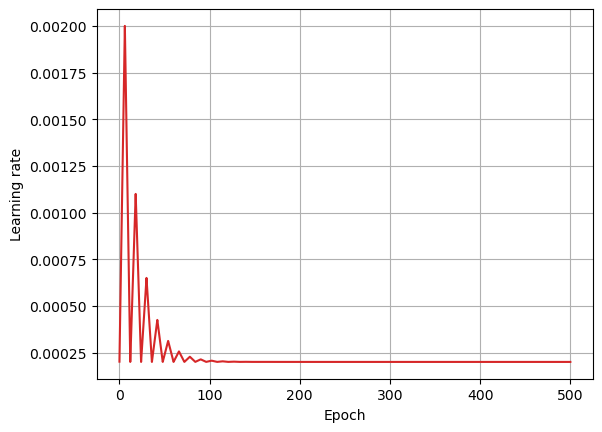

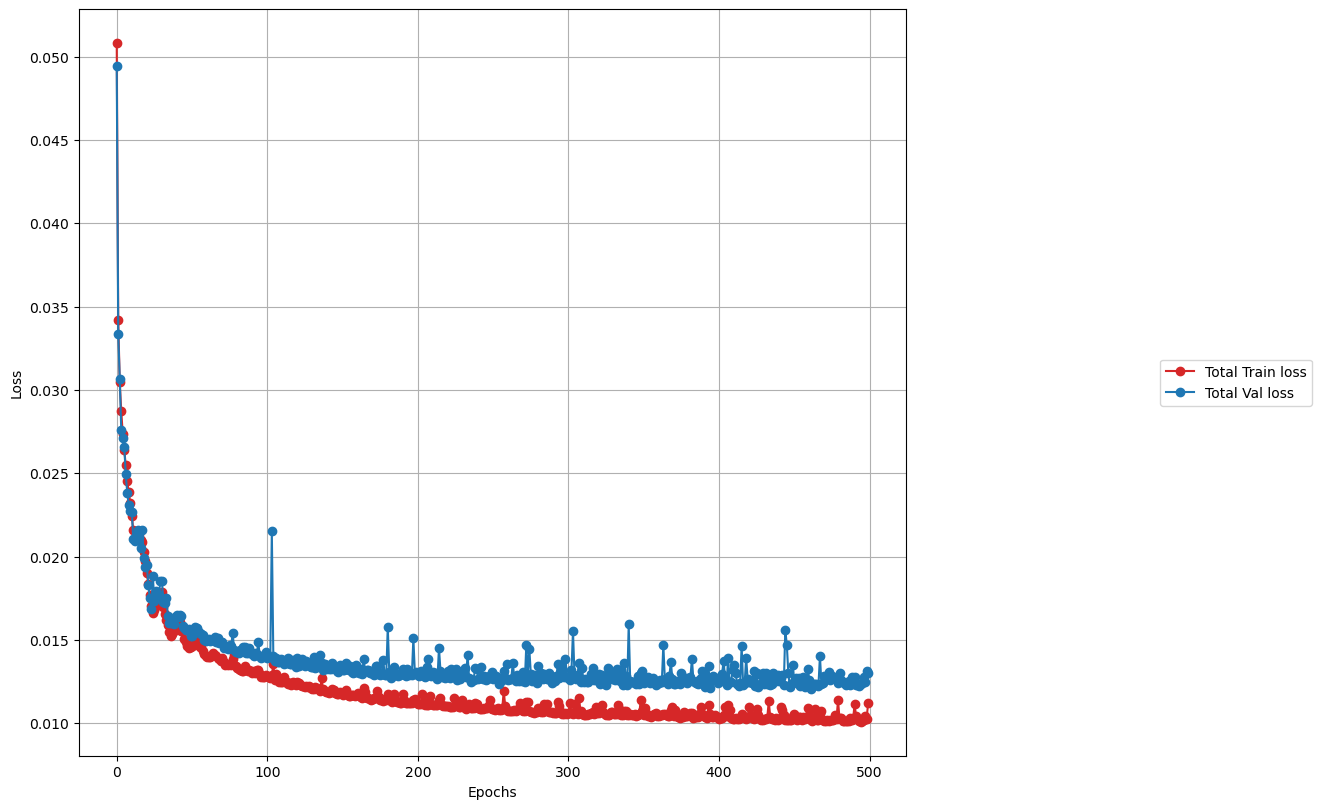

In [12]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")


losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.xlabel("Epochs")
plt.show()

<Figure size 640x480 with 0 Axes>

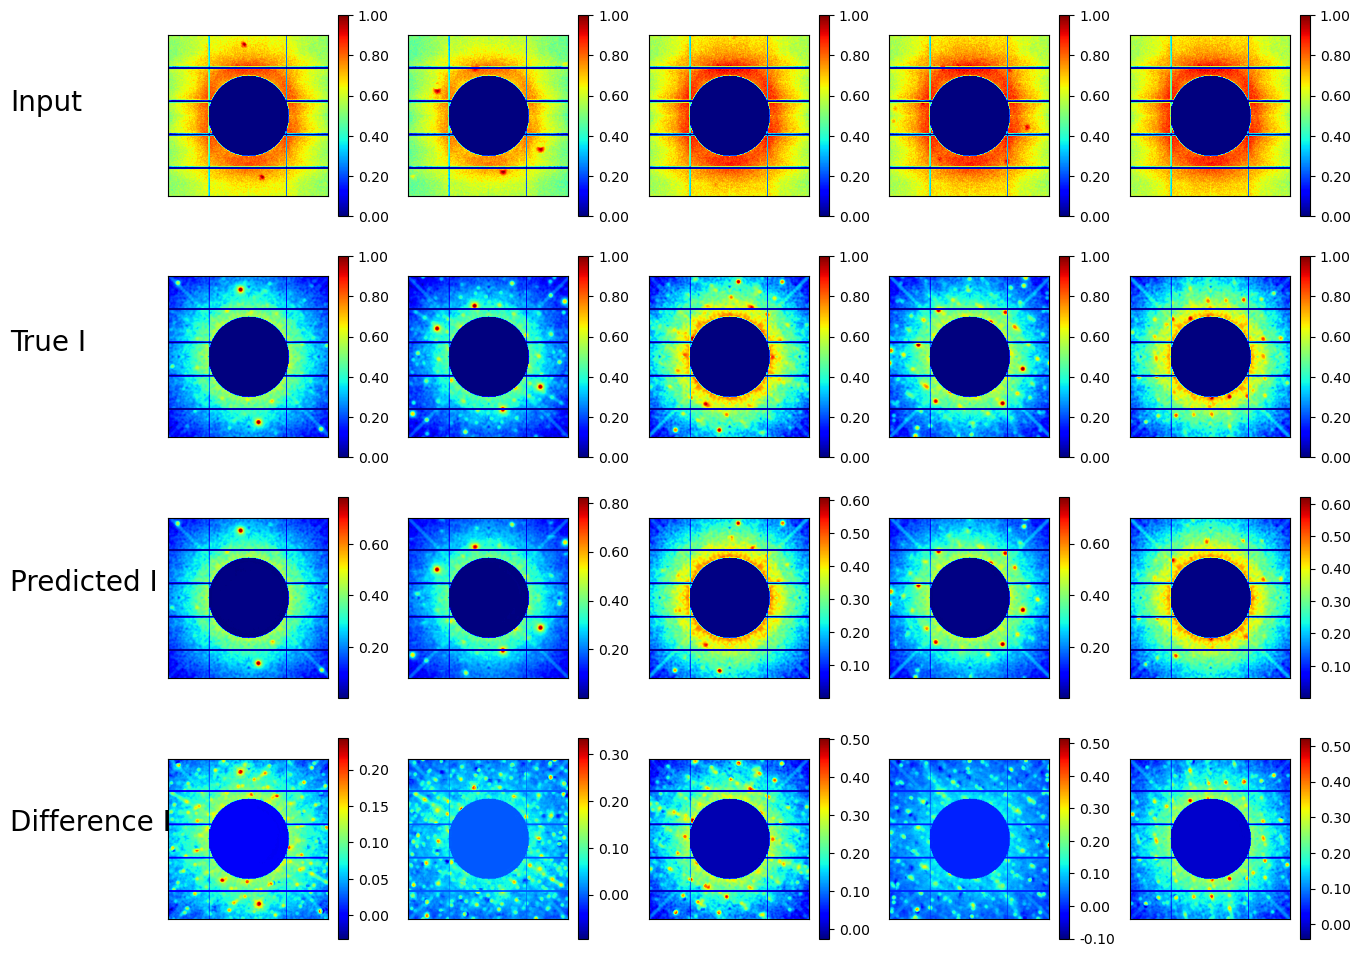

In [13]:
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    testsp = test[1].to(device)
    result = model(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()



h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

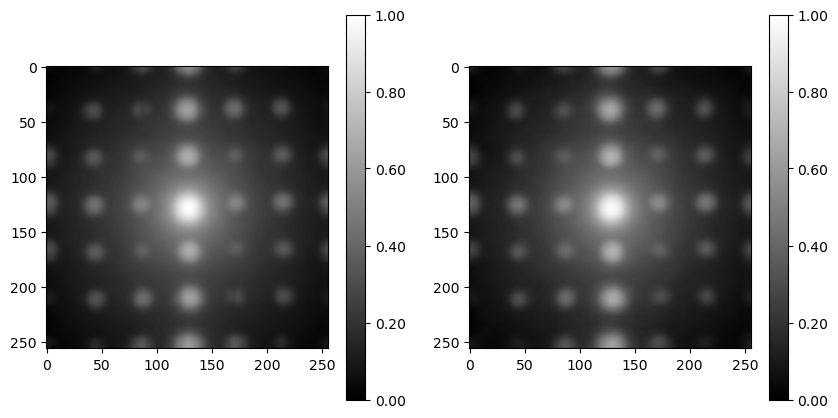

38.36993919777629


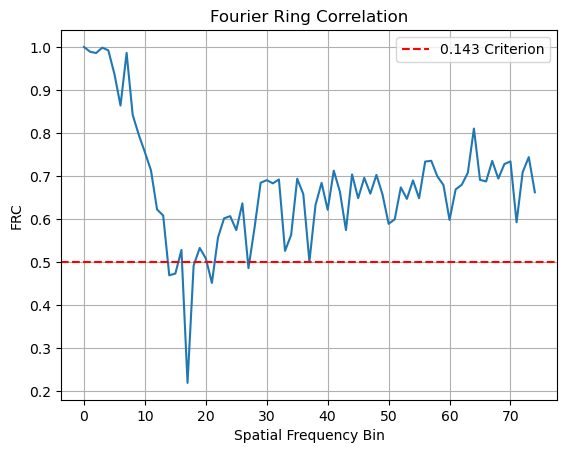

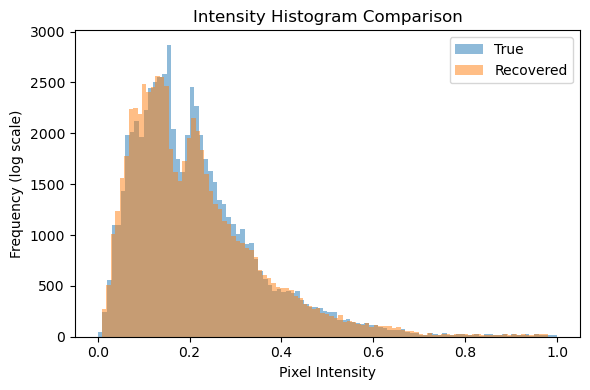

In [15]:
def compute_psnr(img_true, img_recon, max_val=1.0):
    """Compute PSNR between ground truth and reconstructed images."""
    mse = np.mean((img_true - img_recon) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    psnr = 10 * np.log10((max_val ** 2) / mse)
    return psnr

def compute_frc(image1, image2, num_bins=50):
    """Compute the Fourier Ring Correlation between two images."""
    # Compute Fourier transforms
    F1 = fftshift(fft2(image1))
    F2 = fftshift(fft2(image2))

    fig,ax=plt.subplots(1,2,figsize=(10, 5))
    im1=ax[0].imshow(image1, cmap='gray',clim=(0,1))
    im2=ax[1].imshow(image2, cmap='gray',clim=(0,1))
    plt.colorbar(im1, ax=ax[0], format='%.2f')
    plt.colorbar(im2, ax=ax[1], format='%.2f')
    plt.show()
    # Prepare coordinates
    h, w = F1.shape
    y, x = np.indices((h, w))
    center = (h // 2, w // 2)
    r = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)

    # Bin radial frequencies
    r = r.astype(np.int32)
    max_r = min(center)
    frc = np.zeros(num_bins)
    for i in range(num_bins):
        ring_mask = (r >= i * max_r / num_bins) & (r < (i + 1) * max_r / num_bins)
        F1_ring = F1[ring_mask]
        F2_ring = F2[ring_mask]
        num = np.sum(F1_ring * np.conj(F2_ring))
        denom = np.sqrt(np.sum(np.abs(F1_ring) ** 2) * np.sum(np.abs(F2_ring) ** 2))
        frc[i] = np.abs(num / denom) if denom != 0 else 0
    return frc

def plot_intensity_histograms(img1, img2, labels=('True', 'Recovered'), bins=100):
    plt.figure(figsize=(6,4))
    plt.hist(img1.ravel(), bins=bins, alpha=0.5, label=labels[0])
    plt.hist(img2.ravel(), bins=bins, alpha=0.5, label=labels[1])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency (log scale)')
    plt.title('Intensity Histogram Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
j=int(round(np.random.rand()*ntest))
IMAGE1=Y_I_test[j].reshape(h, w)   
IMAGE2=results[j].reshape(h, w)
frc_curve = compute_frc(IMAGE1, IMAGE2,num_bins=75)
print(compute_psnr(IMAGE1, IMAGE2))
plt.plot(frc_curve)
plt.axhline(0.5, color='r', linestyle='--', label='0.143 Criterion')
plt.xlabel('Spatial Frequency Bin')
plt.ylabel('FRC')
plt.title('Fourier Ring Correlation')
plt.legend()
plt.grid(True)
plt.show()
plot_intensity_histograms(IMAGE1, IMAGE2)